# Introduction

This notebook aims to predict the price of electricity in Spain using different algorithms - Linear Regression, XGBRegressor, LSTM, Bidirectional LSTM and Convolution 1D. PyTorch is used in the DL experiment.

**Dataset**: The datasets are in two parts - the enegy generation data and the weather data.

**Walkthough**

 - Data are each imported from drive.
 - Data are each EDA-ed for quick summary.
 - Data are cleaned, outliers removed, missing values dropped or replaced.
 - Preprocessed data are merged to one.
 - Data is run in a scaler->pca pipeline and split.
 - Split data is windowed (extra dimension) for deep learning.
 - Unwindowed data used to treain traditional ML algorithms - LR and XGB.
 - Windowed data used to train DL models


At the end of the model tunings, Bidirectional LSTM had the least RMSE for evaluation - 0.1309.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, shutil
from pathlib import Path
import warnings
import math
import gdown

warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
os.makedirs('featurestore', exist_ok=True)

try:
    shutil.move('/content/energy_dataset.csv', '/content/featurestore/')
    shutil.move('/content/weather_features.csv', '/content/featurestore/')
except:
    pass

In [5]:
gdown.download_folder('https://drive.google.com/drive/u/1/folders/1reuS2JIAFhA6fHp4Yrr9gP4eQXRT_zgD')

Retrieving folder contents


Processing file 1i8X3-m_KbSZDecIAPsBzMzIcwbzo9RhO energy_dataset.csv
Processing file 1Uh7zwi5CZlVKTBavUYVYTtmI_d-8qGed weather_features.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1i8X3-m_KbSZDecIAPsBzMzIcwbzo9RhO
To: /content/featurestore/energy_dataset.csv
100%|██████████| 6.27M/6.27M [00:00<00:00, 36.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uh7zwi5CZlVKTBavUYVYTtmI_d-8qGed
To: /content/featurestore/weather_features.csv
100%|██████████| 19.9M/19.9M [00:00<00:00, 55.0MB/s]
Download completed


['/content/featurestore/energy_dataset.csv',
 '/content/featurestore/weather_features.csv']

In [6]:
energy_df = pd.read_csv('./featurestore/energy_dataset.csv', parse_dates=['time'])
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


# Helper Functions

In [7]:
def visualise_feature(df, feature=None, series=pd.Series([]), label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(25, 12))
    ax.set_xlabel('Time', fontdict={'size': 20, 'weight': 'bold'})

    if feature:
        ax.plot(df[feature][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=20)

    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel)

    if label:
        ax.legend(fontsize=16)

    if title:
        ax.set_title(title, fontdict={'size': 22, 'weight': 'bold'})

    ax.grid(True)
    return ax



def show_feature_bar(df, x, feature='price actual', xlabel=None, title=None, hue=None, label=None):
    plt.figure(figsize=(14,8))
    ax = sns.barplot(data=df, x=x, y=feature, hue=hue, label=label)
    plt.xlabel(xlabel)
    if feature == 'price actual':
        plt.ylabel('Actual Price (€/MWh)')
    else:
        plt.ylabel(feature.title())
    if title:
        plt.title(title, fontdict={'weight': 'bold', 'size': 15})
    if label:
        plt.legend()
    plt.show()
    return ax

# Preprocessing

Here features will be preprocessed for null values, missing values, features drops etc.

### Energy Data Preprocessing

The following steps are taken to preprocess the energy data:

 - Convert the `time` feature to datetime format (UTC) and set it as index.
 - Check for duplicates.
 - Drop irrelevant features - these include features with high missings, forecast features etc.
 - Check for missing values nad replace. If existing, use interpolation to replace them.

In [8]:
energy_df['DateTime'] = pd.to_datetime(energy_df['time'], utc=True, infer_datetime_format=True)
energy_df.drop('time', inplace=True, axis=1)
energy_df.set_index('DateTime', inplace=True)

#### Simple energy data EDA

Explore for missings and duplications

In [9]:
energy_df.shape

(35064, 28)

In [10]:
energy_df.isna().sum()

generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                                  18
generation waste                              

In [11]:
# check for duplicates
energy_df.duplicated().sum()

0

#### Missing Values

Missing values to be checked on the energy data. Features with high missing values will be dropped, others to be handled with extrapolation.

Next, a function is created to drop unwanted features

In [12]:
unwanted_features = set()
def features_to_drop():
    print('The following features are recommended for dropping\n')
    for feature in energy_df.columns:
         # check 1: if feature is zero value
        if energy_df[feature].sum() == 0:
            print(f' - Zero value feature [Z] - "{feature}" sum: {energy_df[feature].sum()}')
            unwanted_features.add(feature)

        # check 2: if feature is null
        if energy_df[feature].isna().sum() / len(energy_df[feature]) > 0.1:
            print(f' - Null value feature [N] - "{feature}" sum: {energy_df[feature].isna().sum()}')
            unwanted_features.add(feature)

        # check 3: if feature is a forecast
        if 'forecast' in feature:
            print(f' - Forecast Feature [FF] - "{feature}" is a forecast.')
            unwanted_features.add(feature)

In [13]:
features_to_drop()

The following features are recommended for dropping

 - Zero value feature [Z] - "generation fossil coal-derived gas" sum: 0.0
 - Zero value feature [Z] - "generation fossil oil shale" sum: 0.0
 - Zero value feature [Z] - "generation fossil peat" sum: 0.0
 - Zero value feature [Z] - "generation geothermal" sum: 0.0
 - Zero value feature [Z] - "generation hydro pumped storage aggregated" sum: 0.0
 - Null value feature [N] - "generation hydro pumped storage aggregated" sum: 35064
 - Zero value feature [Z] - "generation marine" sum: 0.0
 - Zero value feature [Z] - "generation wind offshore" sum: 0.0
 - Forecast Feature [FF] - "forecast solar day ahead" is a forecast.
 - Zero value feature [Z] - "forecast wind offshore eday ahead" sum: 0.0
 - Null value feature [N] - "forecast wind offshore eday ahead" sum: 35064
 - Forecast Feature [FF] - "forecast wind offshore eday ahead" is a forecast.
 - Forecast Feature [FF] - "forecast wind onshore day ahead" is a forecast.
 - Forecast Feature [FF] 

In [14]:
# Now we drop these features

energy_df.drop(list(unwanted_features), axis=1, inplace=True)

In [15]:
print("shape:", energy_df.shape)
energy_df.head()

shape: (35064, 17)


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
DateTime,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


#### Null Values

Next, we check features for null values for further preprocessing

In [16]:
energy_df.isna().sum().sort_values(ascending=False)

total load actual                              36
generation biomass                             19
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation waste                               19
generation fossil gas                          18
generation fossil hard coal                    18
generation hydro water reservoir               18
generation fossil brown coal/lignite           18
generation other                               18
generation other renewable                     18
generation solar                               18
generation wind onshore                        18
generation nuclear                             17
price day ahead                                 0
price actual                                    0
dtype: int64

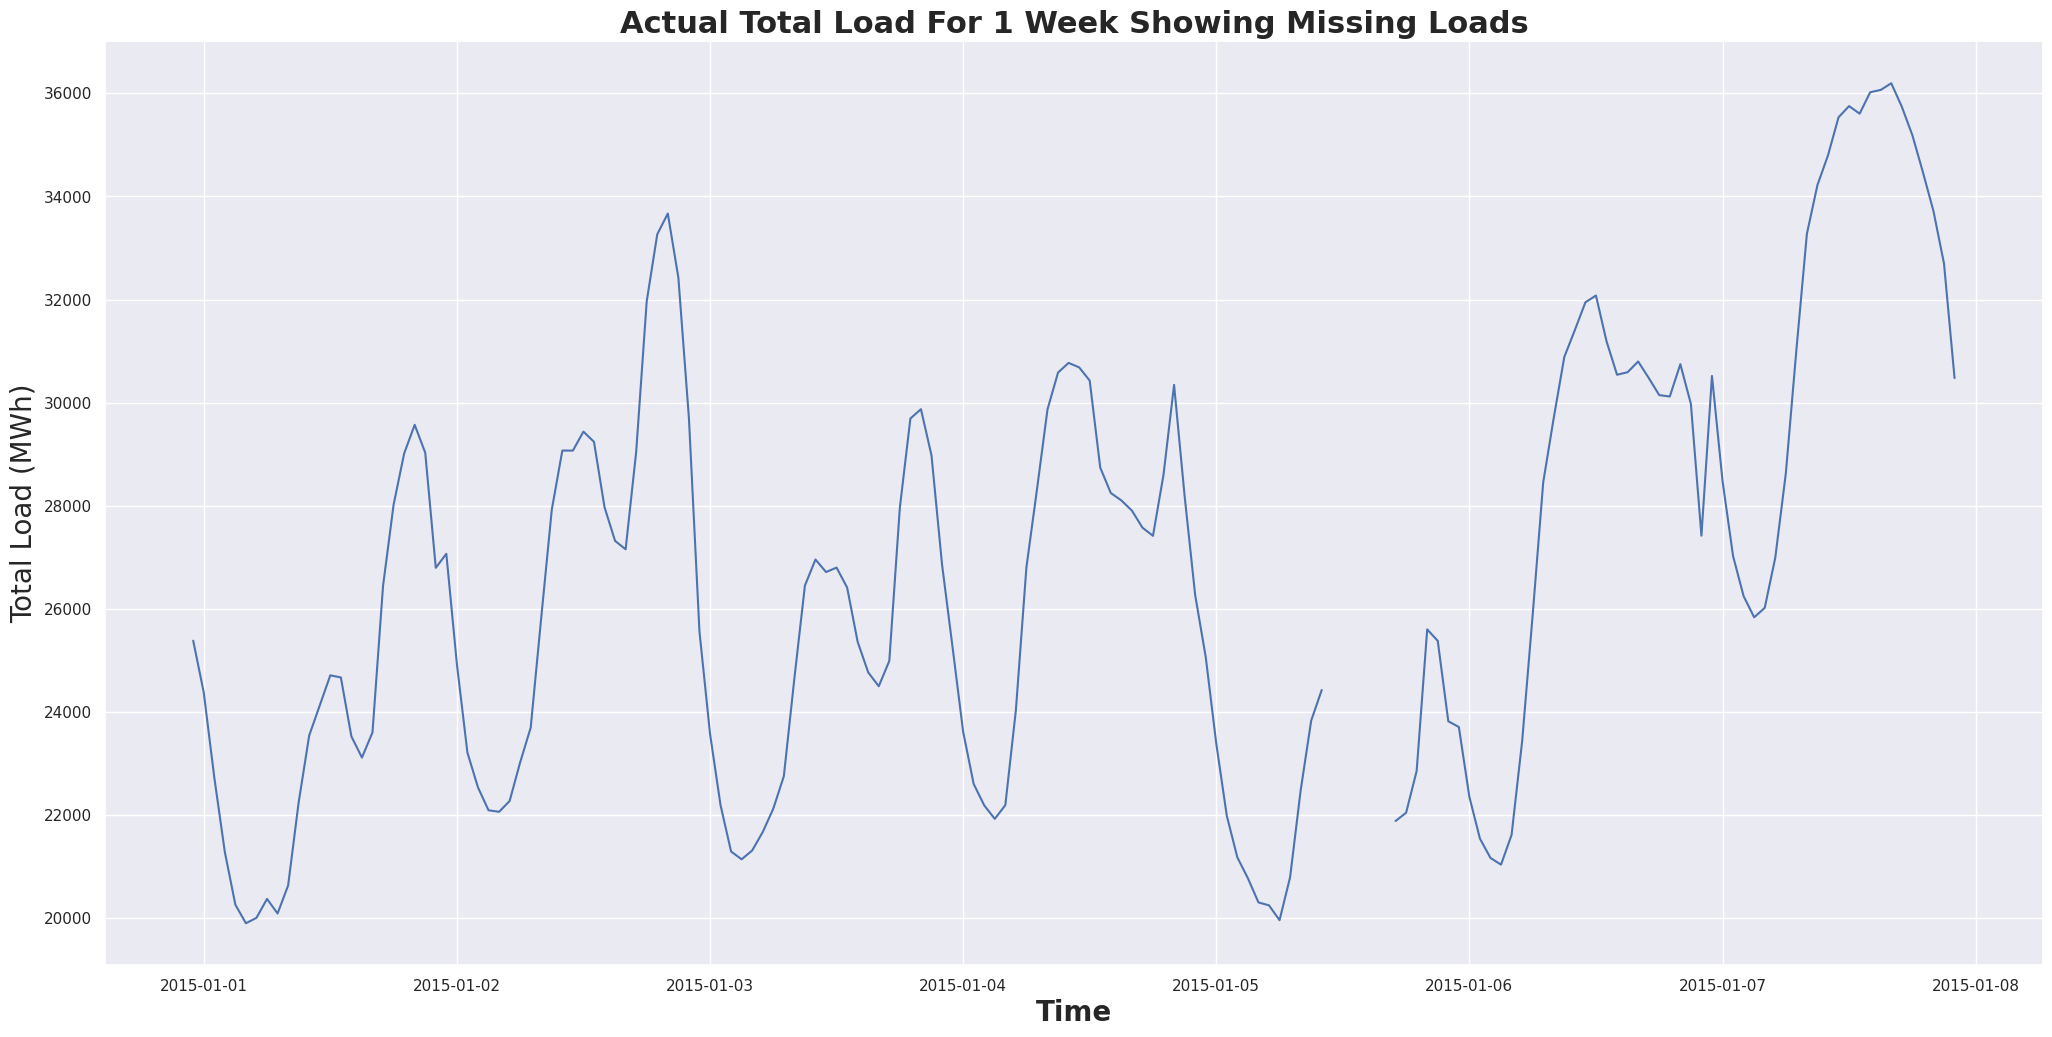

In [17]:
ax = visualise_feature(energy_df, feature='total load actual', ylabel='Total Load (MWh)',
                  title='Actual Total Load For 1 Week Showing Missing Loads', end=24*7)
plt.show()

The figure above is a plot of `Total Loads in MWh for a Week` which show missing values between 5th and 6th of Januray 2015. These missings will be replaced using interpolation technique.

Now, let's interpolate data points to fill missing values

In [18]:
energy_df.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

Next confirm no missing values in the `energy_df`

In [19]:
energy_df.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

Preprocessing is noe complete for `energy_df`. Next is for the `weather_df`

### `Weather Data` Preprocessing

The following steps are taken to preprocess the weather data:
 - Convert the `dt_iso` feature to `datetime` object and set it as index.
 -

In [20]:
weather_df = pd.read_csv('./featurestore/weather_features.csv', parse_dates=['dt_iso'])
weather_df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [21]:
weather_df.shape

(178396, 17)

In [22]:
weather_df['city_name'].value_counts()

city_name
Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: count, dtype: int64

In [23]:
weather_df.rename(columns={'dt_iso': 'DateTime'}, inplace=True)
weather_df['DateTime'] = pd.to_datetime(weather_df['DateTime'], infer_datetime_format=True, utc=True)

weather_df.head()

,DateTime,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Explore data types and description

In [24]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   DateTime             178396 non-null  datetime64[ns, UTC]
 1   city_name            178396 non-null  object             
 2   temp                 178396 non-null  float64            
 3   temp_min             178396 non-null  float64            
 4   temp_max             178396 non-null  float64            
 5   pressure             178396 non-null  int64              
 6   humidity             178396 non-null  int64              
 7   wind_speed           178396 non-null  int64              
 8   wind_deg             178396 non-null  int64              
 9   rain_1h              178396 non-null  float64            
 10  rain_3h              178396 non-null  float64            
 11  snow_3h              178396 non-null  float64            
 12  cl

In [25]:
weather_df.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [26]:
weather_df.shape

(178396, 17)

#### Check for missing

The weather data is checked for any missing values, which will be handled if present.

In [27]:
weather_df.isna().sum()

DateTime               0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

No missing value(s) in data

#### Check for duplications

If duplicates are present, they will be dropped using `[DateTime, city_name]` as reference.

In [28]:
print(f'Duplicated values in dataset: {weather_df.duplicated().sum()}')

Duplicated values in dataset: 21


In [29]:
# Now we drop the duplicates

weather_df = weather_df.reset_index().drop_duplicates(subset=['DateTime', 'city_name'],
                                                   keep='first').set_index('DateTime')
print(f'Observations after dropping duplicates: {weather_df.shape[0]}')
weather_df.sample(10)

Observations after dropping duplicates: 175320


,index,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
DateTime,,,,,,,,,,,,,,,,,
2016-07-18 16:00:00+00:00,48796,Madrid,310.725000,310.725000,310.725000,957,22,1,84,0.0,0.0,0.0,32,802,clouds,scattered clouds,03d
2015-09-09 13:00:00+00:00,113440,Barcelona,297.890000,294.820000,301.480000,1016,50,3,160,0.0,0.0,0.0,20,801,clouds,few clouds,02d
2015-06-30 23:00:00+00:00,4347,Valencia,296.200000,294.250000,299.150000,1017,61,0,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-05-23 14:00:00+00:00,172971,Seville,298.540000,298.150000,299.150000,1014,47,2,320,0.0,0.0,0.0,0,800,clear,sky is clear,01d
2018-07-10 20:00:00+00:00,174135,Seville,299.360000,298.150000,300.150000,1015,69,5,220,0.0,0.0,0.0,0,800,clear,sky is clear,01d
2015-01-31 16:00:00+00:00,108100,Barcelona,283.425656,283.425656,283.425656,990,72,2,137,0.3,0.0,0.0,28,500,rain,light rain,10
2015-04-26 23:00:00+00:00,37929,Madrid,280.545000,280.545000,280.545000,951,96,3,262,0.3,0.0,0.0,12,500,rain,light rain,10n
2016-01-21 17:00:00+00:00,9273,Valencia,285.635000,285.635000,285.635000,1022,64,2,70,0.0,0.0,0.0,0,800,clear,sky is clear,01
2017-05-09 11:00:00+00:00,20678,Valencia,295.150000,295.150000,295.150000,1010,64,3,90,0.0,0.0,0.0,20,801,clouds,few clouds,02d


#### Cleaning and encoding

Categorising `weather_main` feature into the following and creating a new `status` feature:

```

cold (Snow): 'snow'

moderate (Rain): 'rain', 'drizzle'

warm: 'mist', 'fog', 'smoke', 'haze', 'dust'

stormy: 'thunderstorm', 'squall', 'clouds', 'clear'

```

This is followed by encoding the `status` and then dropping some features.

In [30]:
def get_weather_status(category):
    match category:
        case 'snow':
            return 'snow'
        case 'rain' | 'drizzle':
            return 'moderate'
        case 'mist' | 'fog' | 'smoke' | 'haze' | 'dust':
            return 'humid'
        case 'thunderstorm' | 'squall' | 'clouds' | 'clear':
            return 'stormy'
        case _ :
            return pd.NA

In [31]:
try:
    # categorise weather_main
    weather_df['status'] = weather_df['weather_main'].apply(lambda x: get_weather_status(x))
    # encode status
    status_df = pd.get_dummies(weather_df['status'], drop_first=True).astype('int')
    # drop features
    weather_df.drop(['weather_id', 'weather_main', 'weather_description', 'weather_icon', 'index', 'status'], axis=1, inplace=True)

    # convert temps to celcius
    # for col in ['temp', 'temp_min', 'temp_max']:
    #     weather_df[col] = weather_df[col].apply(lambda temp: temp - 273)

except KeyError as e:
    print(f'\033[91m Error: {e} \033[0m')
    print('feature(s) already dropped or not found.')

In [32]:
weather_df = pd.concat([weather_df, status_df], axis=1)
print(weather_df.shape)
weather_df.sample(10)

assert weather_df.shape[1] == 15, 'multiple merge'

(175320, 15)


#### Outliers: Pressure and Wind_Speed

The average pressure range is 970hPa - 1050hPa. Values outside this range will be converted to nan and interpolation will be used to replace the nans.
Extreme values of wind_speed will also be processed in same manner.

Oultiers in pressure features

In [33]:
weather_df['pressure'].max(), weather_df['pressure'].min()

(1008371, 0)

In [34]:
def show_outliers(feature):
    plt.figure(figsize=(16,6))
    sns.boxplot(x=weather_df[feature])
    plt.title(f'Outliers in {feature}')
    plt.show()

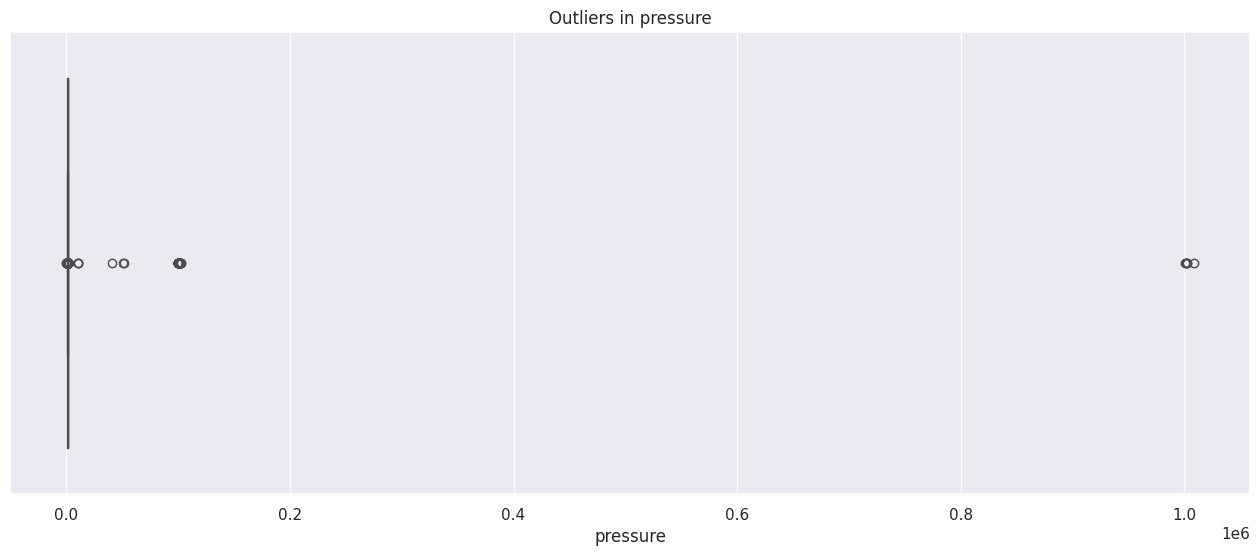

In [35]:
show_outliers('pressure')

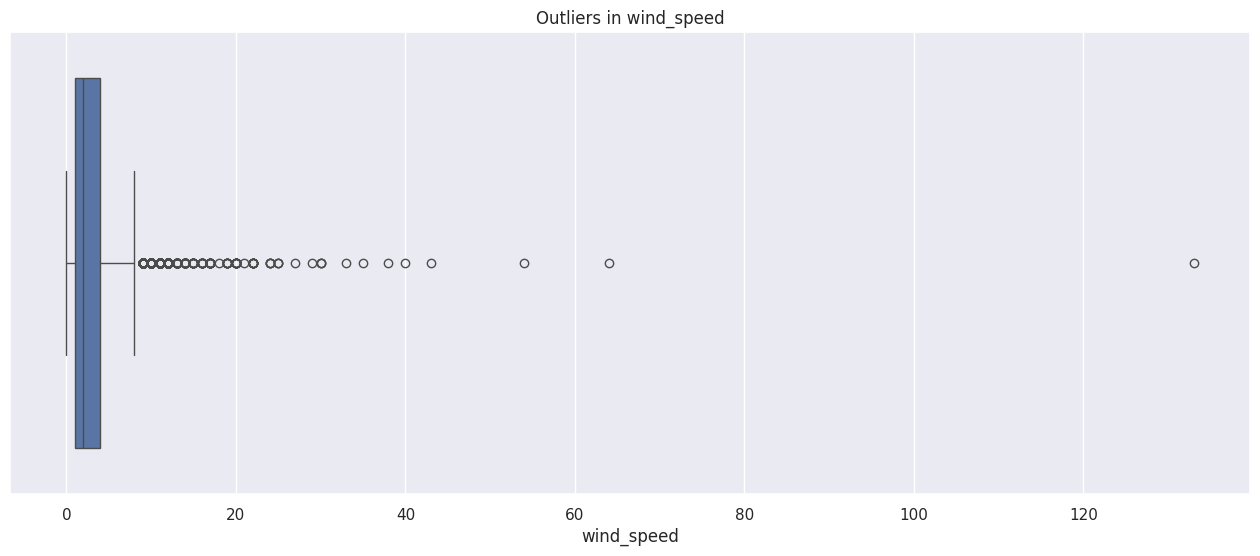

In [36]:
show_outliers('wind_speed')

Now replace the outliers with nan

In [37]:
weather_df.loc[(weather_df['pressure'] > 1050) | (weather_df['pressure'] < 930), 'pressure'] = np.nan
weather_df.loc[(weather_df['wind_speed'] > 65)] = np.nan

Next is interpolation

In [38]:
weather_df.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

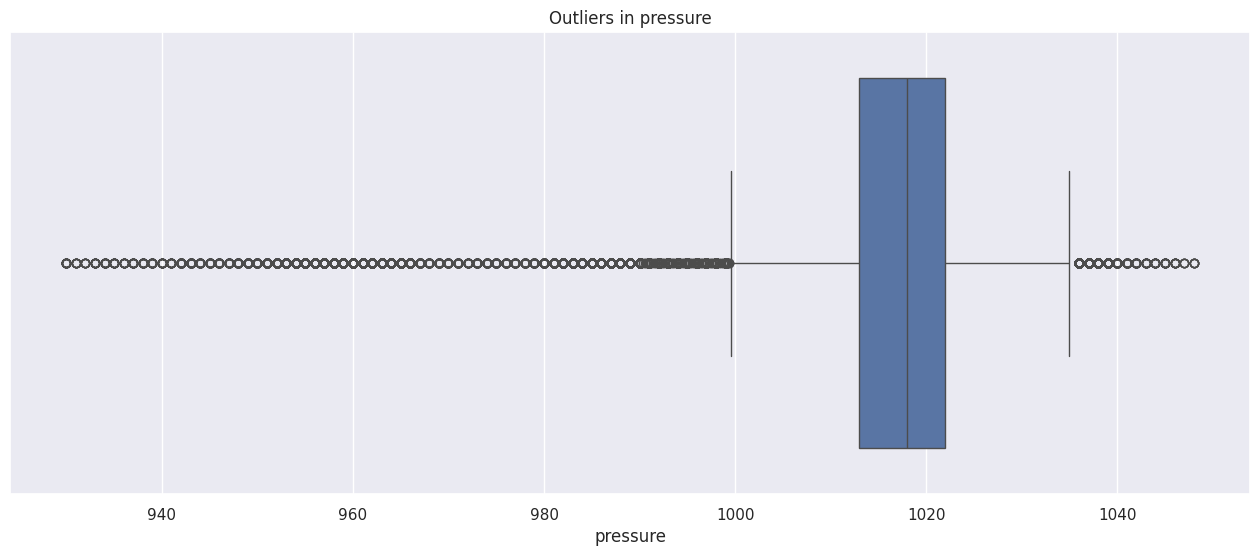

In [39]:
show_outliers('pressure')

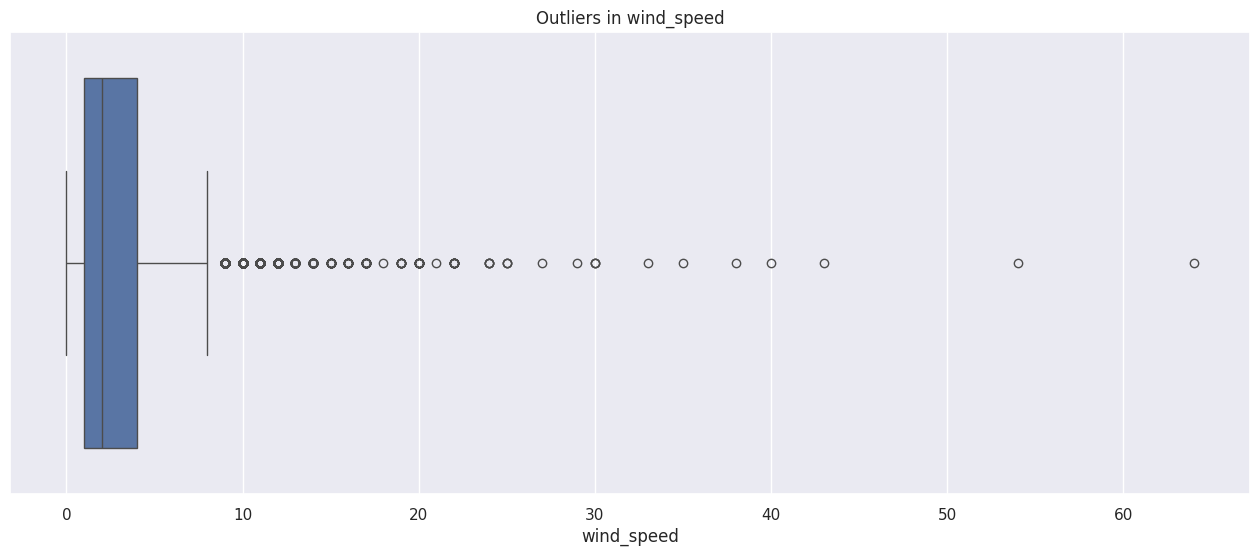

In [40]:
show_outliers('wind_speed')

#### Waehter data splits

Next the weather data is going to be split by `city_name` so we can merge with the `energy_df`

In [41]:
grouped = weather_df.groupby('city_name')
for city in grouped.groups.keys():
    print(f'{city} has {len(grouped.get_group(city))} observations')

 Barcelona has 35064 observations
Bilbao has 35064 observations
Madrid has 35064 observations
Seville has 35064 observations
Valencia has 35063 observations


In [42]:
weather_df['city_name'].replace({' Barcelona': 'Barcelona'}, inplace=True)

In [43]:
weather_df.city_name.value_counts()

city_name
Madrid       35064
Bilbao       35064
Barcelona    35064
Seville      35064
Valencia     35063
Name: count, dtype: int64

In [44]:
# barcelona, bilbao, madrid, seville, valencia = [city for _, city in weather_df.groupby('city_name')]
city_df = [city for _, city in weather_df.groupby('city_name')]

In [45]:
type(city_df)

list

In [46]:

for city in city_df:
    print(city['city_name'].unique()[0])

Barcelona
Bilbao
Madrid
Seville
Valencia


In [47]:
data = energy_df.copy()

for city in city_df:
    name = city['city_name'].unique()[0]
    suffixes = ('', f'_{name}')  # Specify suffixes for overlapping columns
    data = data.merge(city, on=['DateTime'], how='outer', suffixes=suffixes)

data.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,moderate,snow,stormy,city_name_Bilbao,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,moderate_Bilbao,snow_Bilbao,stormy_Bilbao,city_name_Madrid,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,moderate_Madrid,snow_Madrid,stormy_Madrid,city_name_Seville,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,moderate_Seville,snow_Seville,stormy_Seville,city_name_Valencia,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,moderate_Valencia,snow_Valencia,stormy_Valencia
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,Barcelona,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Bilbao,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Madrid,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Seville,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,Barcelona,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Bilbao,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Madrid,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Seville,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Bilbao,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Madrid,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Seville,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Bilbao,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Madrid,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Seville,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,Barcelona,281.286,281.286,281.286,1036.0,100.0,7.0,

In [48]:
data.shape

(35064, 92)

In [49]:
data.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
city_name                                      0
temp                                           0
temp_min                                       0
temp_max            

In [50]:
data.interpolate(method='linear', limit_direction='both', axis=0, inplace=True)
data.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
city_name                                      0
temp                                           0
temp_min                                       0
temp_max            

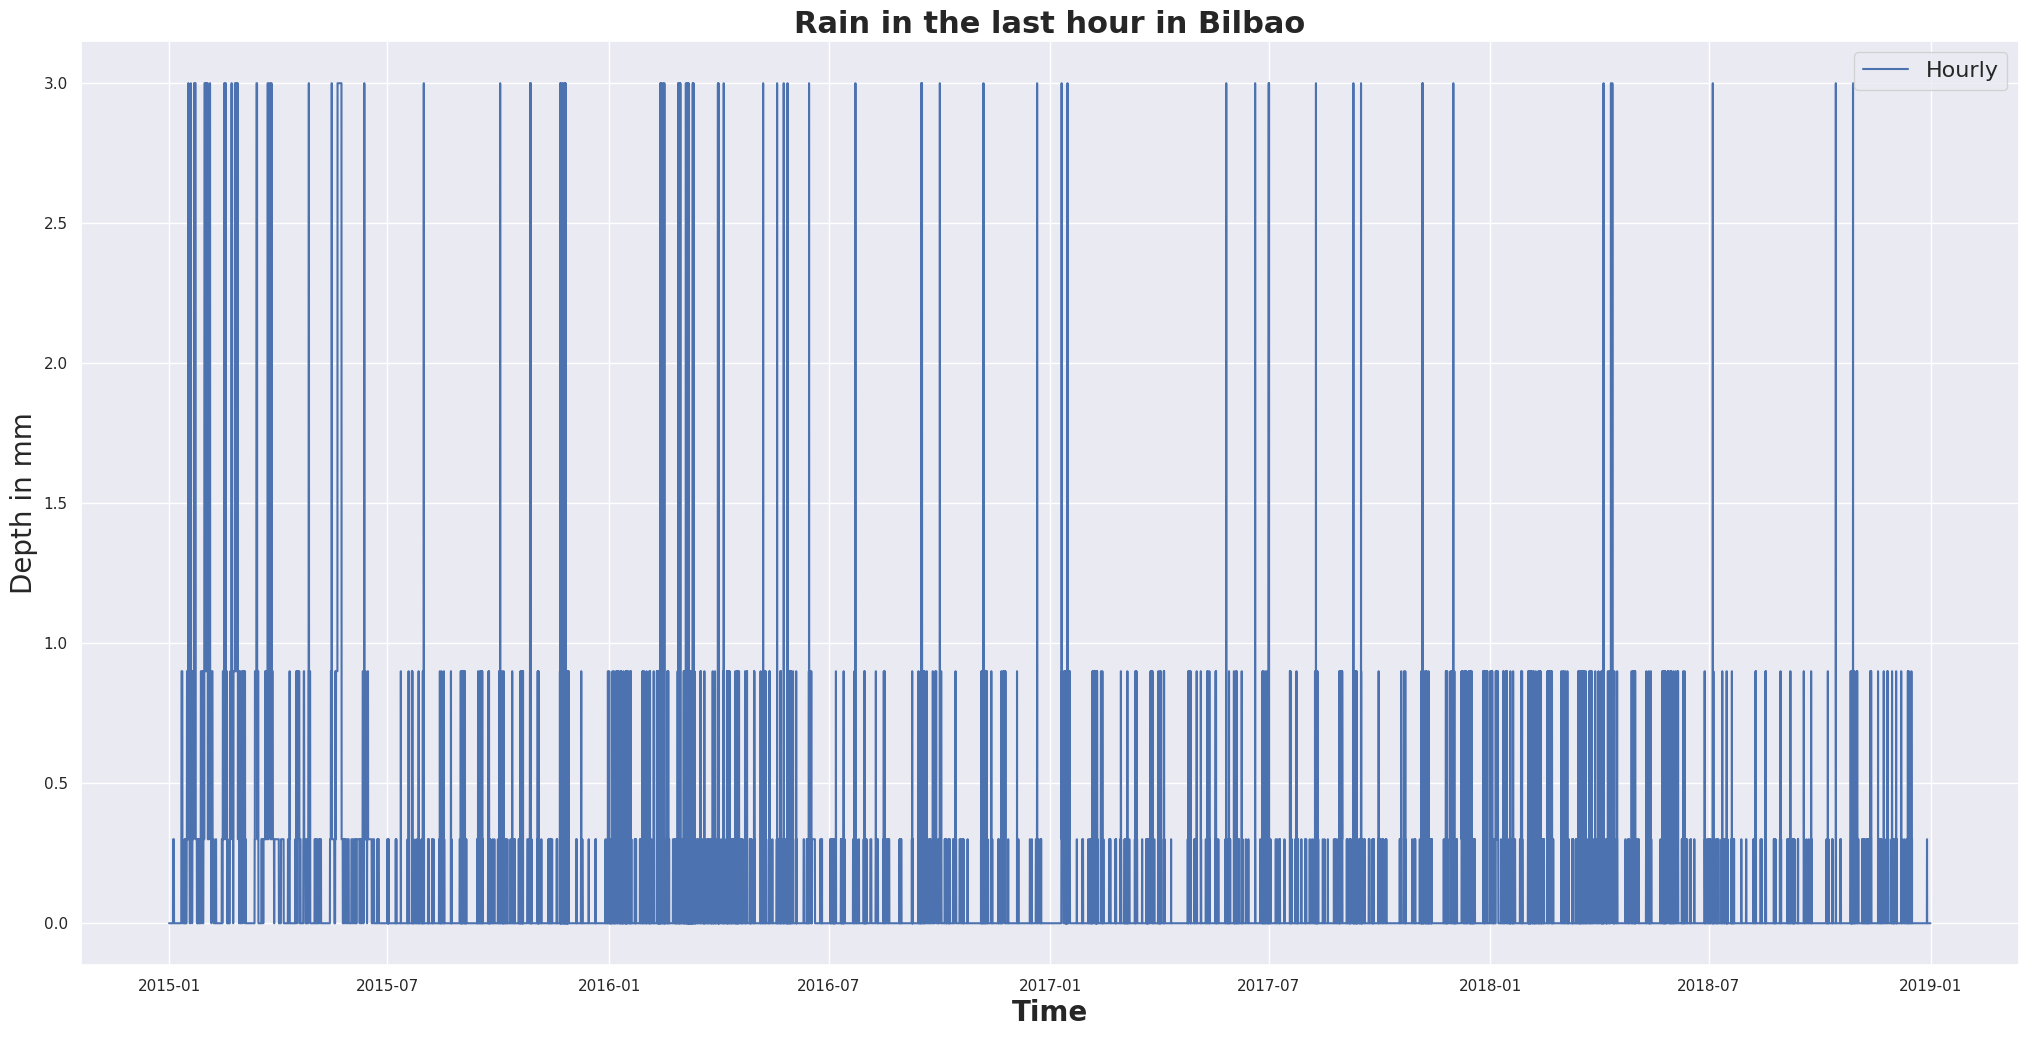

In [51]:
ax = visualise_feature(data, 'rain_1h_Bilbao',
                 label='Hourly', ylabel='Depth in mm',
                 title='Rain in the last hour in Bilbao')
plt.show()

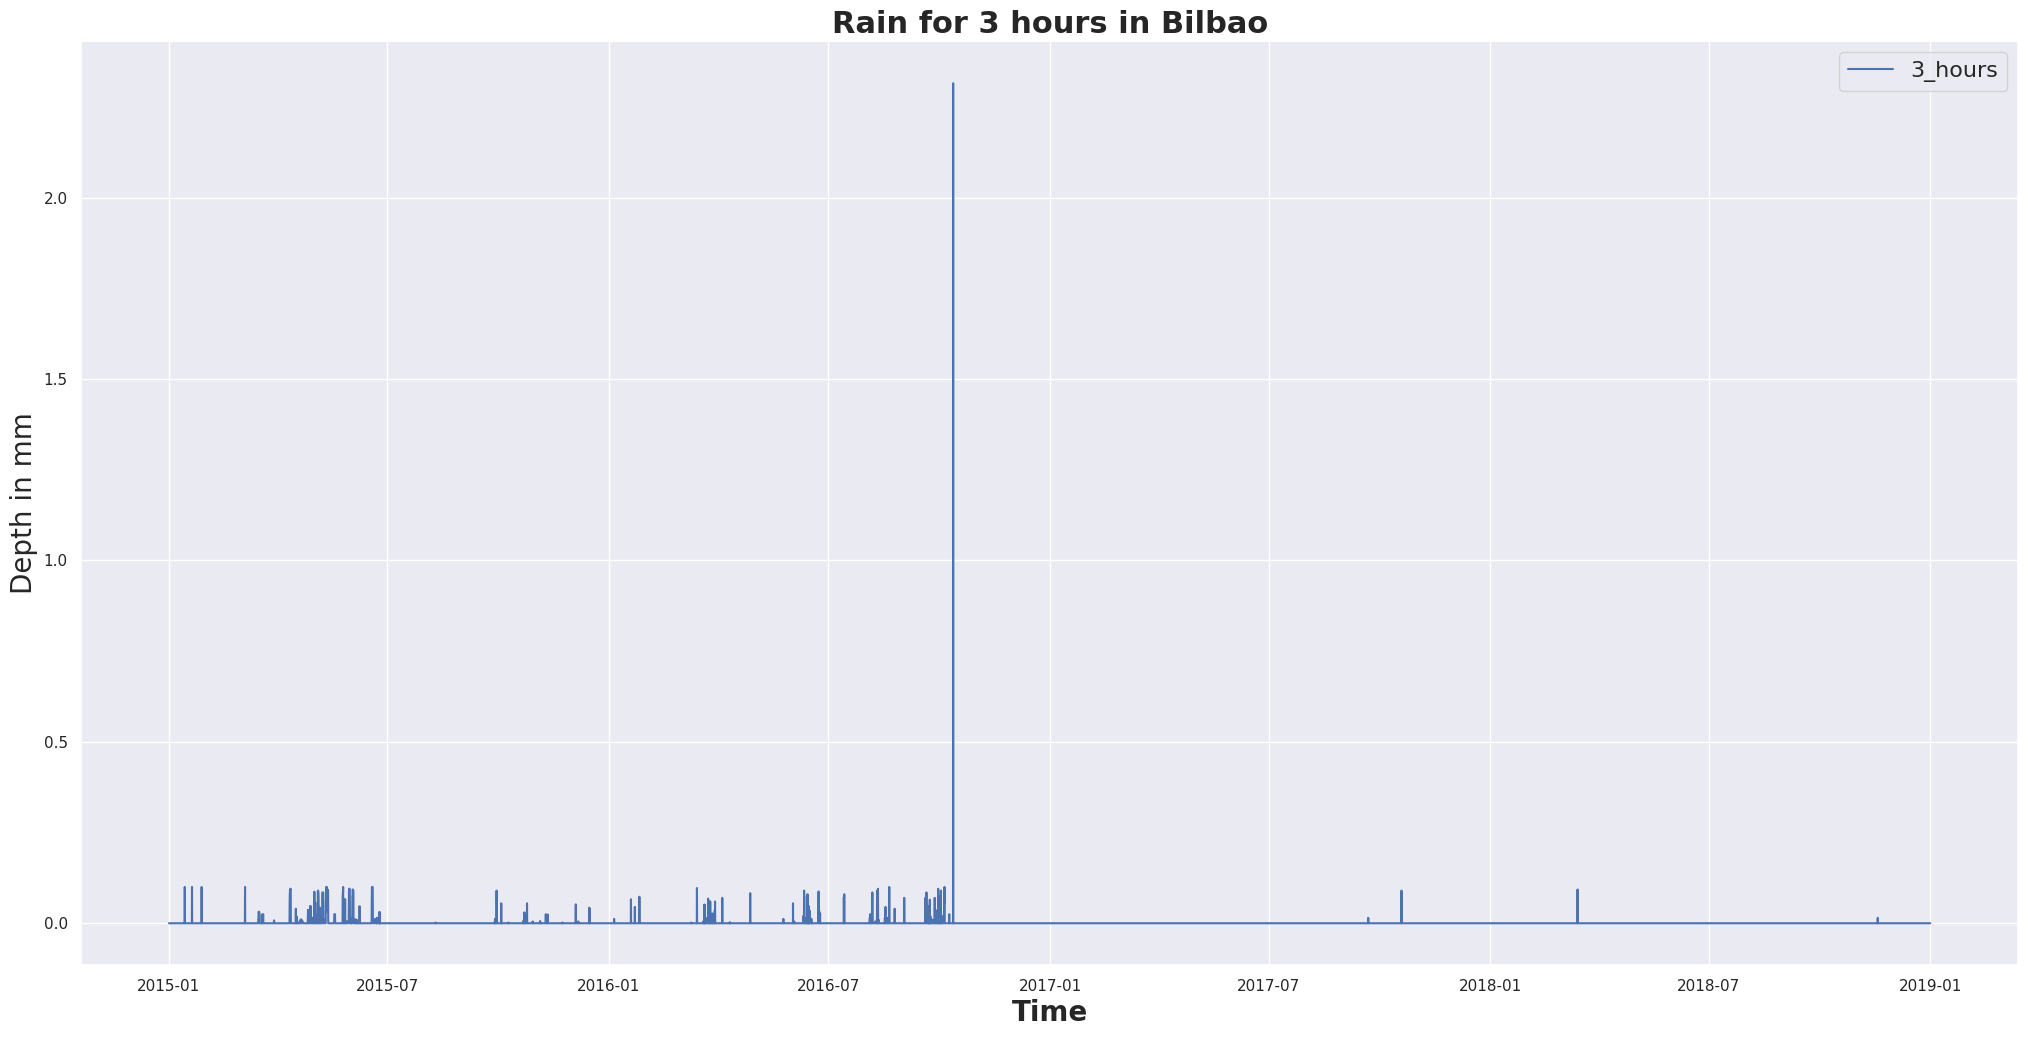

In [52]:
ax = visualise_feature(data, 'rain_3h_Bilbao',
                 label='3_hours', ylabel='Depth in mm',
                 title='Rain for 3 hours in Bilbao')
plt.show()

From the chart above, the 3 hour rain is scanty and unrealiable. So this feature will be dropped across the cities.

In [53]:
for col in data.columns:
    if '_3h' in col or 'city_name' in col:
        data.drop([col], inplace=True, axis=1)

In [54]:
data.shape

(35064, 77)

In [55]:
data.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'clouds_all', 'moderate', 'snow', 'stormy', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'clouds_all_Bilbao', 'moderate_Bilbao', 'snow_Bilbao',
       'stormy_Bilbao', 'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid',
       'pressure_Madrid'

## Visual EDA For Combined Data

The combined data is visually explored to understand price and energy generation patterns.

### 14 day moving average of price.

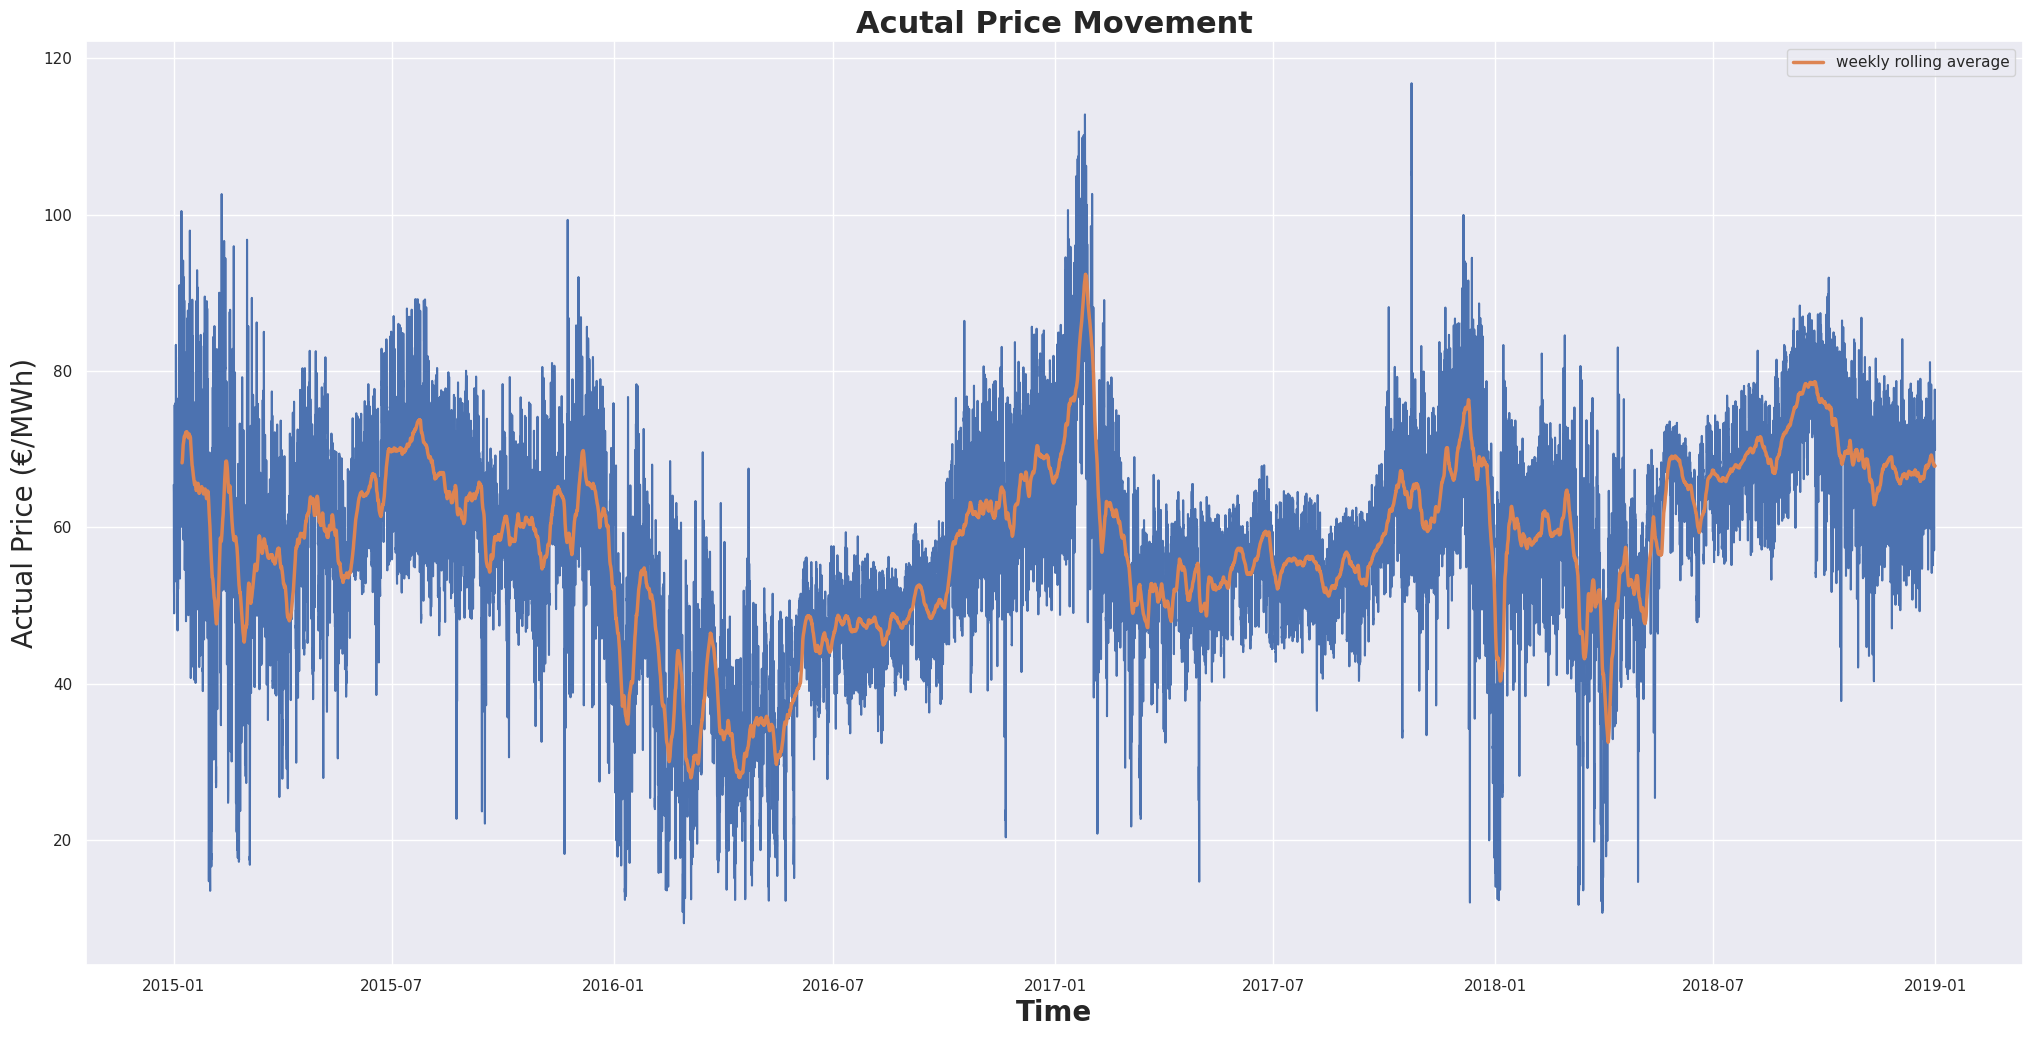

In [56]:
rolling_price_actual = data['price actual'].rolling(24*7).mean()
ax = visualise_feature(data, 'price actual', ylabel='Actual Price (€/MWh)', title='Acutal Price Movement')
ax.plot(rolling_price_actual, linewidth=2.5, label='weekly rolling average')
plt.legend()
plt.show()

Plot shows trends and seasonality in the data. Let's zoom in to get a better view.

The data is sliced to 24hrs by 14 days or 2 weeks, or any 24 hrs with a slide of 14 days.

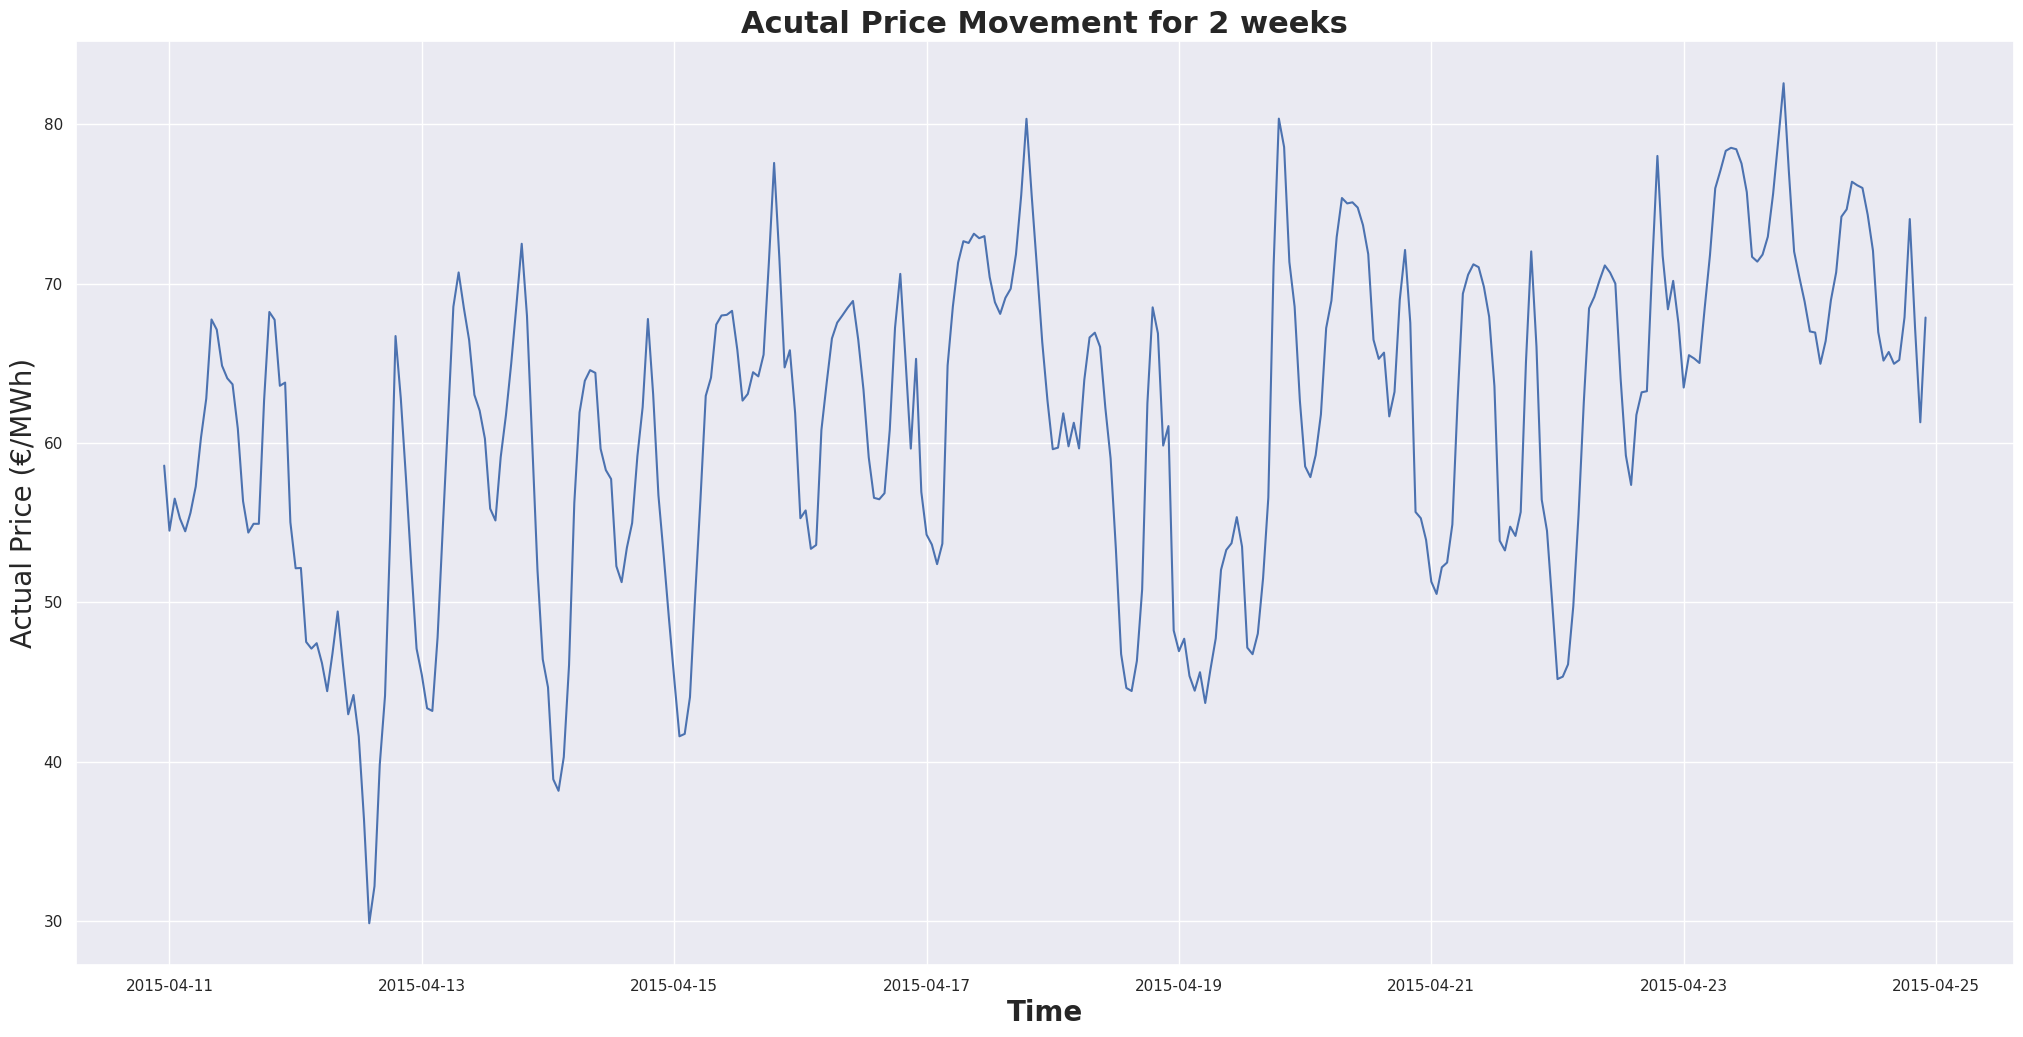

In [57]:
ax = visualise_feature(data.iloc[24*100:24*114, :], 'price actual', ylabel='Actual Price (€/MWh)', title='Acutal Price Movement for 2 weeks')

For the average scale, the price exists between 25 and 95.

### Price by month

Next we check which day of month were price hikes experienced.

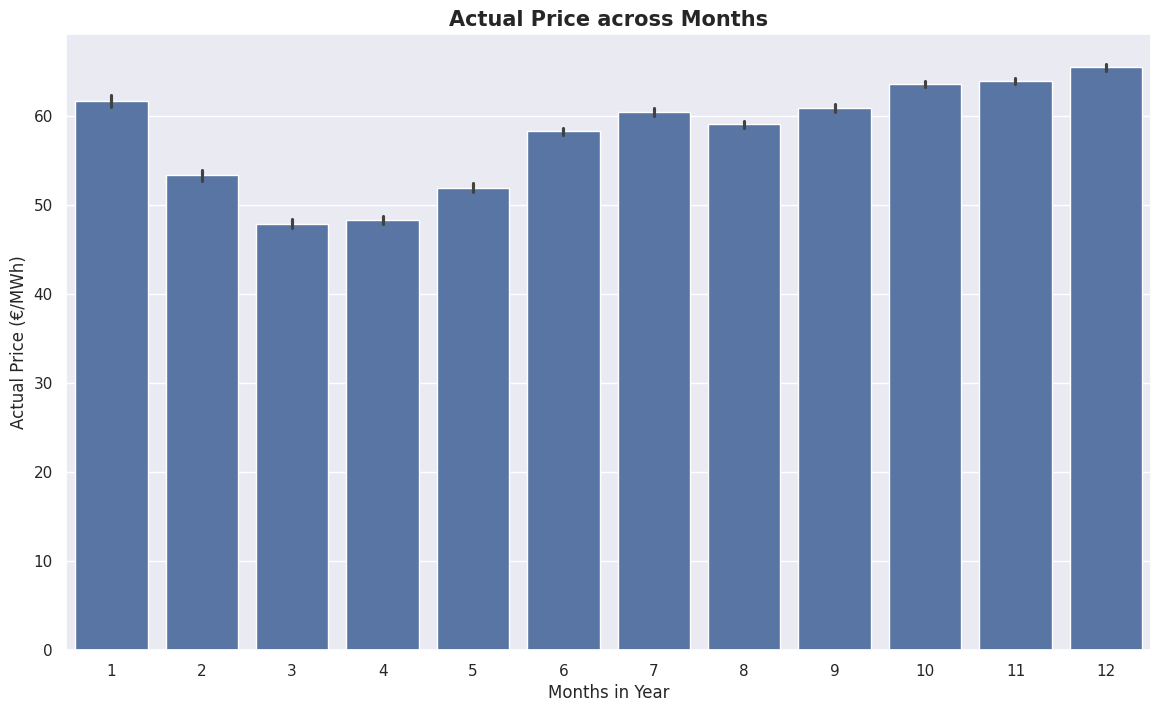

<Axes: title={'center': 'Actual Price across Months'}, xlabel='Months in Year', ylabel='Actual Price (€/MWh)'>

In [58]:
show_feature_bar(data, x=data.index.month, xlabel='Months in Year', title='Actual Price across Months')

December, November, October and January experienced highest prices while March and April had the least.

### Price of energy by days

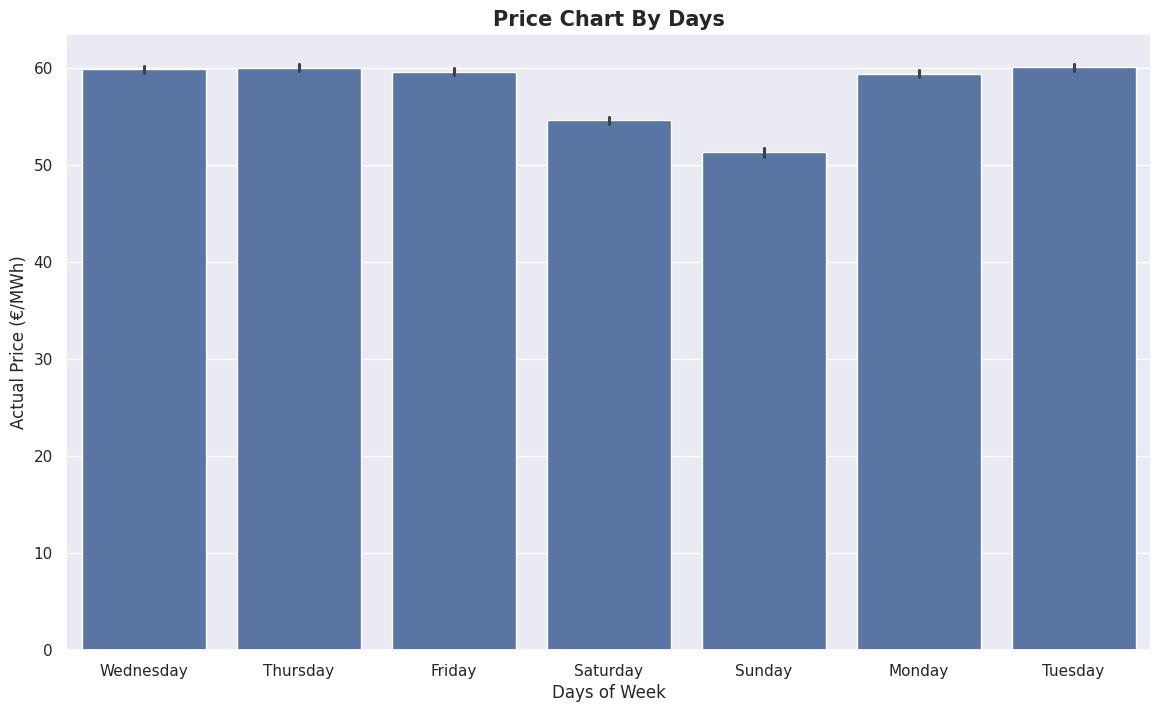

<Axes: title={'center': 'Price Chart By Days'}, xlabel='Days of Week', ylabel='Actual Price (€/MWh)'>

In [59]:
show_feature_bar(data, x=data.index.day_name(), xlabel='Days of Week', title='Price Chart By Days')

Highest prices were paid on Wednesdays, Thursdays, and Tuesdays, while least payment was Sundays.

### price by time

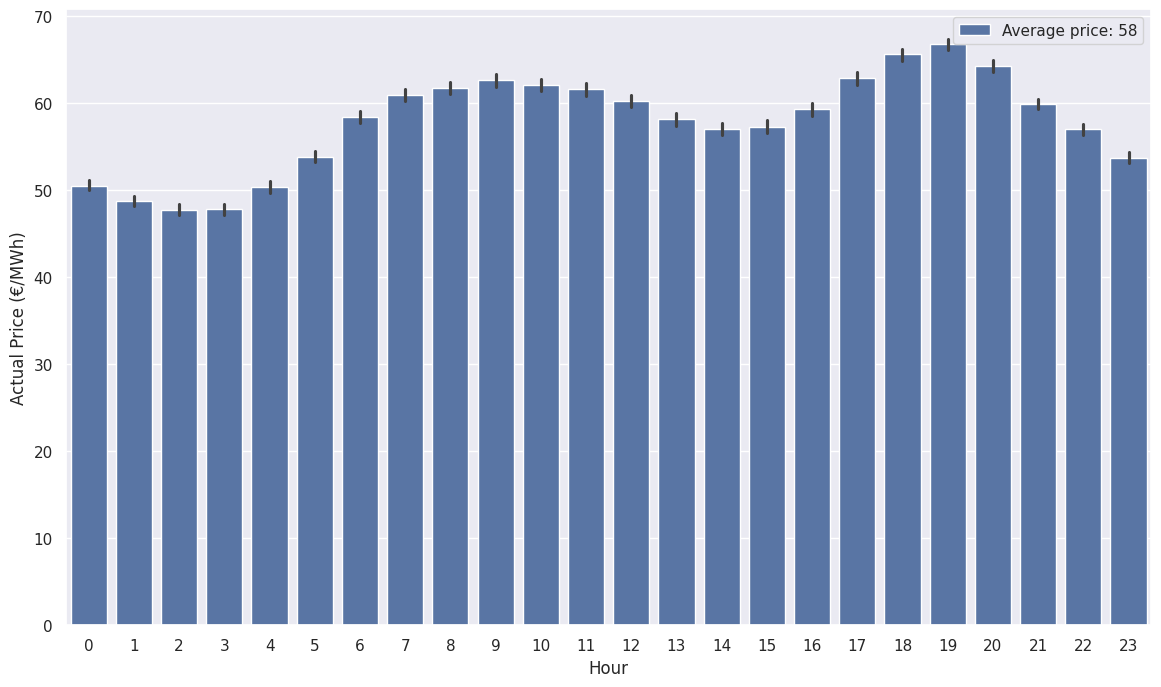

In [60]:
average = data['price actual'].mean()
ax = show_feature_bar(data, x=data.index.hour, xlabel='Hour', label=f'Average price: {average:.0f}')


High prices observed from 7AM to 9PM.

In [61]:
data.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'clouds_all', 'moderate', 'snow', 'stormy', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'clouds_all_Bilbao', 'moderate_Bilbao', 'snow_Bilbao',
       'stormy_Bilbao', 'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid',
       'pressure_Madrid'

Of course, the Sun shines brightest in summer months.

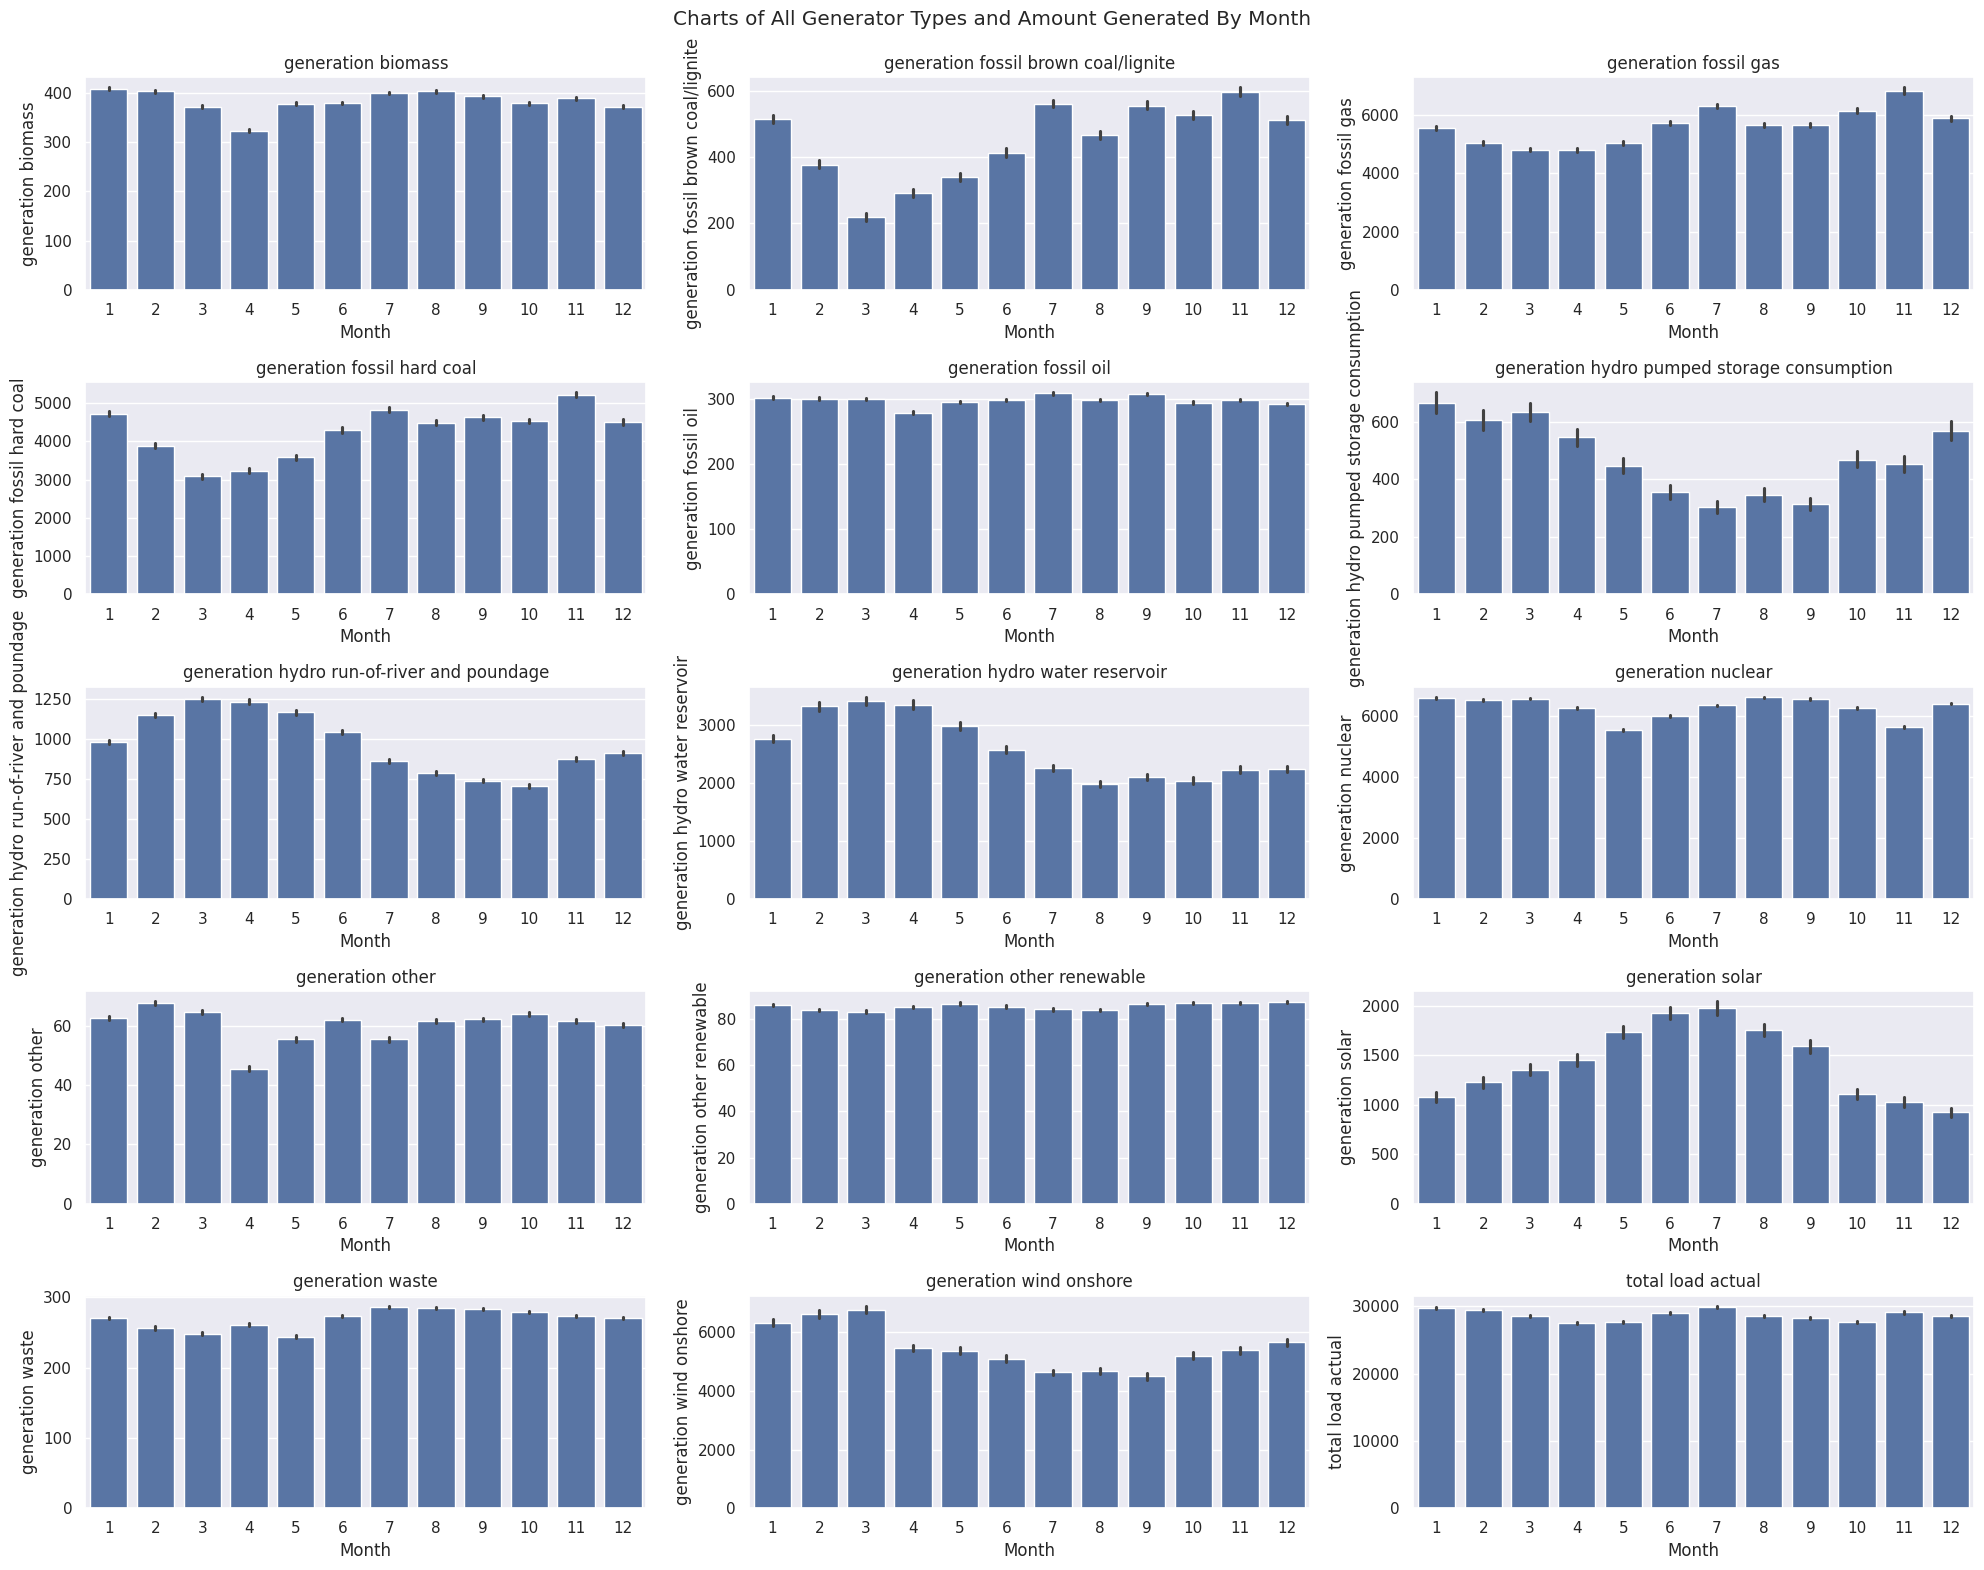

In [62]:
generators = ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual']

fig, axes = plt.subplots(5, 3, figsize=(20, 16))
fig.suptitle('Charts of All Generator Types and Amount Generated By Month\n', fontdict={'weight': 'bold', 'size': 20})

for i, (generator, ax) in enumerate(zip(generators, axes.flat)):
    sns.barplot(data=data, x=data.index.month, y=generator, ax=ax)
    ax.set_title(generator)
    ax.set_xlabel('Month')

plt.tight_layout()

# Hide unused subplots
# for ax in range(len(generators), len(axes.flat)):
#     axes.flat[ax].set_visible(False)


<b>Observations</b>

 - The solar generation pattern is more or less the opposite of hydro-generations patterns across the year.
 - Fosil fuel and other renewables are almost constant through the year.
 - Biomass, waste, and generation other follow same pattern.
 - Nuclear generation shows quarterly seasonality.

In [63]:
change = data['price actual'].div(data['price actual'].shift(-1)).mul(100)
change.describe()

count    35063.000000
mean       100.258070
std          7.204186
min         47.446053
25%         97.428603
50%        100.315884
75%        103.220688
max        222.097820
Name: price actual, dtype: float64

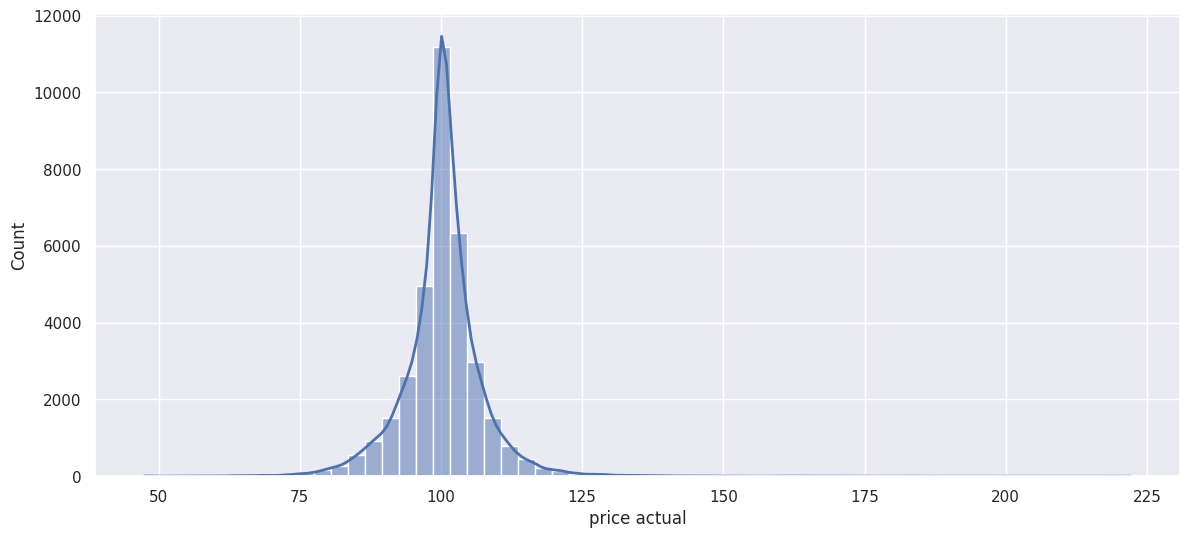

In [64]:
plt.figure(figsize=(14,6))
sns.histplot(change, bins=100, kde=True, binwidth=3, line_kws={'linewidth': 2});

from the chat above, it can be seen that the price change occur between 75 and 125 Euro, with the average being 100 Euro.

## Statisitcal Analyses

Statistical analyses are carried out in this section. This include correlation of price and features, Augmented Dickey-Fuller test (unit root test), analysis of partial and auto-correlated functions to check for relationship between a value and its lags.

In [65]:
data.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,moderate,snow,stormy,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,moderate_Bilbao,snow_Bilbao,stormy_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,moderate_Madrid,snow_Madrid,stormy_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,moderate_Seville,snow_Seville,stormy_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,moderate_Valencia,snow_Valencia,stormy_Valencia
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,1.0,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,0.0,1.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,1.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,1.0,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,0.0,1.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,1.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,1.0,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,0.0,1.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,1.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,1.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,1.0,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,0.0,1.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,1.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,1.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,1.0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,1.0,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,0.0,1.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,1.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,1.0,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,1.0


In [66]:
correlations = data.corr()

print(correlations['price actual'].sort_values(ascending=False))

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure                                       0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133135
pressure_Valencia                              0.109812
temp_min                                       0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

features `'snow_Valencia', 'snow_Seville'` have undefined correlations with price so they'll be dropped.

In [67]:
data.drop(['snow_Valencia', 'snow_Seville'], axis=1, inplace=True)

#### ADF (unit root) test

We are going to test for unit root in the price feature. If there's a unit root (null hypothesis, H<sub>0</sub>, p-value > 0.05 or 5%) , that means there's the series is not stationary and there's a need for differencing to achieve stationarity for proper analysis. Otherwise, we accept the alternate hypothesis (p-value <= 0.05, H<sub>1</sub>) that thre's no unit root in the series.

> Return values

 - adf: The test statistic.
 - pvalue: MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).
 - usedlag: The number of lags used.
 - nobs: The number of observations used for the ADF regression and calculation of the critical values.
 - critical values - dict: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
 - icbest: The maximized information criterion if autolag is not None.

From the returned values, we're interested in the `p-value` - index 1.

In [68]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


adf = adfuller(data['price actual'], regression='c', maxlag=25)

p_value = adf[1]
p_value

3.8586339421390634e-24

The p-value, or significannt, is less than 0..05. So there is no unit root, hence no differencing required for stationarity.

#### ACF and PACF tests

While autocorrelation (ACF) tells us about the direct relationship between a variable and its lagged values, partial autocorrelation (PACF) tells us about the direct relationship between a variable and its lagged values after removing the effect of inbetween lags.

<Figure size 1800x600 with 0 Axes>

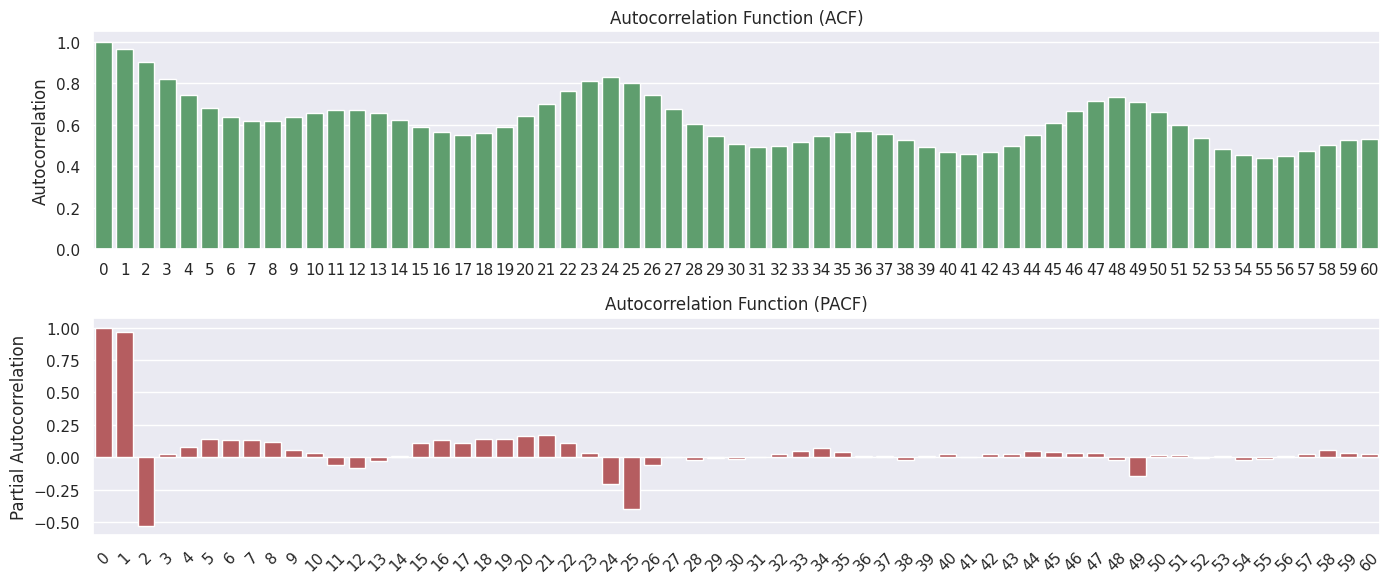

In [69]:
plt.figure(figsize=(18, 6))
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 6))
sns.barplot(acf(data['price actual'], nlags=60), label='ACF', ax=ax1, color='g')
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_ylabel('Autocorrelation')

sns.barplot(pacf(data['price actual'], nlags=60), label='PACF', ax=ax2, color='r')
ax2.set_title('Autocorrelation Function (PACF)')
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_xticklabels(ax2.get_xticks(), rotation=45)
plt.tight_layout()
plt.show()

The PACF plot shows that strong relationship for a price at time t, P<sub>t</sub> and at times t-1, t-2, t-24, t-25 (P<sub>t-1</sub>, P<sub>t-2</sub>, P<sub>t-24</sub>, P<sub>t-25</sub>). After these lags, relationships decays.

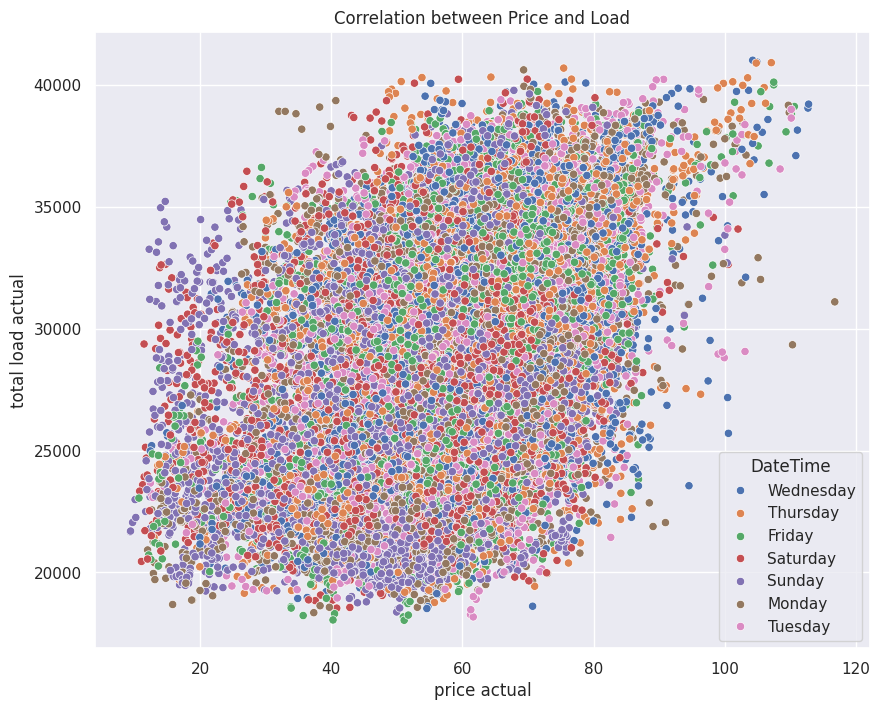

In [70]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data['price actual'], y=data['total load actual'], hue=data.index.day_name())
plt.title('Correlation between Price and Load');

The scatterplot shows a postive correlation between price and total load. It can be seen mostly that least prices occur on Sundays and Mondays, while higher values happens on Wednesdays and Thurdays.

# Feature Engineering

Here we'll create features from exisiting features

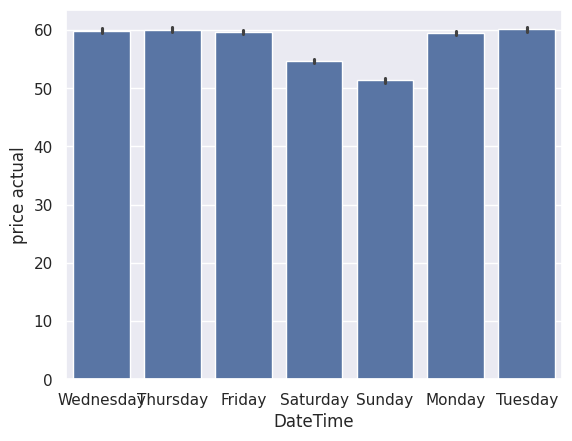

In [71]:
sns.barplot(x=data.index.day_name(), y=data['price actual']);

## Feature Generation

Since the energy use depends on the time of day and day of week, and month, we'll generate hour, weekday, and month features. For this data:

 - weekdays: days of the week where prices are higher - Mon - Fri
 - hours: hours of day of observed high prices - 7AM-9PM.

In [72]:
# get business hour

business_hour = ((data.index.hour > 6) & (data.index.hour < 21))
business_day = (data.index.weekday < 5 ) # Mon (0) - Fri (4)
data['business_hour_day'] = (business_hour & business_day).astype('int')
data.sample(10)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,moderate,snow,stormy,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,moderate_Bilbao,snow_Bilbao,stormy_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,moderate_Madrid,snow_Madrid,stormy_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,moderate_Seville,stormy_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,moderate_Valencia,stormy_Valencia,business_hour_day
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-10-23 22:00:00+00:00,325.0,939.0,5885.0,3807.0,288.0,168.0,357.0,439.0,5901.0,52.0,90.0,150.0,286.0,3294.0,24837.0,58.59,63.63,287.6500,286.1500,289.1500,1024.0,93.0,1.0,280.0,0.0,0.0,0.0,0.0,1.0,282.380,280.150,285.150,1027.0,87.0,2.0,90.0,0.0,0.0,0.0,0.0,1.0,285.58,285.15,286.15,1026.0,54.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,292.5400,292.1500,293.1500,1021.0,68.0,2.0,140.0,0.0,0.0,0.0,1.0,288.1500,288.1500,288.1500,1024.0,87.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2018-05-16 13:00:00+00:00,282.0,0.0,4000.0,2167.0,320.0,0.0,1552.0,2673.0,5984.0,61.0,101.0,5397.0,182.0,5563.0,30596.0,56.40,62.78,294.1500,293.1500,295.1500,1016.0,56.0,4.0,120.0,0.0,0.0,0.0,0.0,1.0,286.930,285.150,289.150,1022.0,72.0,4.0,300.0,0.0,75.0,0.0,0.0,1.0,294.91,292.15,296.15,1016.0,33.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,301.1500,301.1500,301.1500,1011.0,28.0,6.0,110.0,0.0,0.0,0.0,1.0,296.1500,296.1500,296.1500,1017.0,35.0,4.0,120.0,0.0,20.0,0.0,1.0,1
2016-04-04 20:00:00+00:00,381.0,0.0,3995.0,1605.0,348.0,0.0,1863.0,6844.0,7096.0,54.0,81.0,17.0,152.0,5910.0,31338.0,30.30,39.15,287.1500,287.1500,287.1500,1004.0,93.0,1.0,90.0,0.0,20.0,1.0,0.0,0.0,282.480,281.150,284.150,1005.0,87.0,3.0,300.0,0.0,90.0,0.0,0.0,1.0,281.51,281.15,282.15,1001.0,93.0,0.0,0.0,0.0,75.0,1.0,0.0,0.0,288.5900,286.1500,293.1500,1006.0,93.0,4.0,270.0,0.0,20.0,0.0,1.0,286.4600,285.9500,287.1500,1002.0,100.0,2.0,130.0,0.9,75.0,1.0,0.0,1
2015-11-07 08:00:00+00:00,502.0,904.0,4757.0,7023.0,317.0,195.0,585.0,1167.0,6027.0,87.0,69.0,3080.0,260.0,3692.0,28473.0,51.31,62.05,289.3185,289.3185,289.3185,1027.0,79.0,2.0,271.0,0.0,10.0,0.0,0.0,1.0,288.256,288.256,288.256,1024.0,72.0,1.0,203.0,0.0,6.0,0.0,0.0,1.0,283.65,283.65,283.65,1028.0,96.0,1.0,340.0,0.0,12.0,0.0,0.0,1.0,291.9635,291.9635,291.9635,1023.0,79.0,3.0,55.0,0.0,0.0,0.0,1.0,288.2185,288.2185,288.2185,1027.0,86.0,1.0,137.0,0.0,0.0,0.0,1.0,0
2018-08-04 16:00:00+00:00,227.0,0.0,3766.0,1261.0,206.0,3071.0,1866.0,3630.0,5690.0,13.0,92.0,1783.0,308.0,7813.0,24262.0,27.27,69.79,306.1500,306.1500,306.1500,1016.0,41.0,5.0,130.0,0.0,20.0,0.0,0.0,1.0,301.700,301.150,302.150,1021.0,69.0,4.0,310.0,0.0,20.0,0.0,0.0,1.0,311.40,310.15,312.15,1018.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,312.1500,312.1500,312.1500,1012.0,22.0,5.0,240.0,0.0,0.0,0.0,1.0,307.1500,307.1500,307.1500,1015.0,38.0,5.0,120.0,0.0,20.0,0.0,1.0,0
2015-09-22 16:00:00+00:00,506.0,656.0,4343.0,4598.0,292.0,386.0,564.0,927.0,6913.0,80.0,70.0,3617.0,250.0,7947.0,30832.0,44.00,52.90,295.2900,292.5900,297.5900,1010.0,73.0,3.0,90.0,0.0,40.0,0.0,0.0,1.0,292.160,291.150,293.710,1017.0,77.0,8.0,330.0,0.0,75.0,0.0,0.0,1.0,303.15,303.15,303.15,1012.0,9.0,5.0,290.0,0.0,0.0

### Data Splitting

Split data into train and validaton subsets

In [73]:
features, label = data.drop('price actual', axis=1), data['price actual']

def split_data(xx, yy, train_size=0.8):
    train = int(len(xx) * train_size)
    X_train, y_train = xx[:train], yy[:train]
    X_val, y_val = xx[train:], yy[train:]

    return (X_train, y_train), (X_val, y_val)

(X_train, y_train), (X_val, y_val) = split_data(features, label)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((28051, 75), (28051,), (7013, 75), (7013,))

In [74]:
X_val.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,moderate,snow,stormy,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,moderate_Bilbao,snow_Bilbao,stormy_Bilbao,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,moderate_Madrid,snow_Madrid,stormy_Madrid,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,moderate_Seville,stormy_Seville,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,moderate_Valencia,stormy_Valencia,business_hour_day
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-14 18:00:00+00:00,251.0,0.0,5319.0,1068.0,345.0,761.0,1849.0,6391.0,6068.0,60.0,102.0,31.0,277.0,14265.0,35044.0,37.61,286.65,286.15,287.15,1006.0,82.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,284.82,282.15,288.15,995.0,62.0,8.0,230.0,0.9,75.0,1.0,0.0,0.0,284.55,281.15,286.15,1000.0,93.0,6.0,200.0,3.0,90.0,1.0,0.0,0.0,289.61,289.15,290.15,1007.0,82.0,12.0,220.0,0.3,75.0,1.0,0.0,291.15,291.15,291.15,1004.0,55.0,1.0,0.0,0.0,20.0,0.0,1.0,1
2018-03-14 19:00:00+00:00,252.0,0.0,5292.0,1126.0,351.0,149.0,1821.0,6756.0,6068.0,55.0,101.0,27.0,290.0,13306.0,36230.0,48.21,286.15,286.15,286.15,1005.0,82.0,4.0,207.0,0.0,0.0,0.0,0.0,1.0,283.83,281.15,287.15,992.0,58.0,8.0,190.0,0.3,40.0,1.0,0.0,0.0,284.34,282.15,285.15,999.0,93.0,5.0,200.0,0.9,90.0,1.0,0.0,0.0,289.54,289.15,290.15,1007.0,82.0,12.0,220.0,0.0,75.0,0.0,1.0,290.15,290.15,290.15,1004.0,67.0,2.0,40.0,0.0,20.0,0.0,1.0,1
2018-03-14 20:00:00+00:00,256.0,0.0,4318.0,1054.0,351.0,168.0,1853.0,6104.0,6068.0,53.0,103.0,17.0,294.0,12970.0,35065.0,41.11,286.15,286.15,286.15,1005.0,93.0,1.0,140.0,0.0,75.0,0.0,0.0,1.0,284.83,282.15,288.15,994.0,47.0,5.0,250.0,0.0,40.0,0.0,0.0,1.0,282.95,281.15,284.15,1000.0,93.0,7.0,290.0,0.9,75.0,1.0,0.0,0.0,288.54,288.15,289.15,1006.0,87.0,11.0,220.0,0.3,75.0,1.0,0.0,289.15,289.15,289.15,1004.0,72.0,2.0,290.0,0.0,20.0,0.0,1.0,1
2018-03-14 21:00:00+00:00,254.0,0.0,4047.0,963.0,350.0,811.0,1853.0,5347.0,6073.0,54.0,104.0,17.0,288.0,13090.0,32328.0,36.72,286.15,286.15,286.15,1004.0,87.0,1.0,150.0,0.0,0.0,0.0,0.0,1.0,283.83,281.15,287.15,995.0,54.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,281.80,281.15,282.15,1001.0,93.0,3.0,240.0,0.9,75.0,1.0,0.0,0.0,289.15,289.15,289.15,1005.0,87.0,9.0,210.0,0.0,75.0,0.0,1.0,289.15,289.15,289.15,1003.0,72.0,1.0,310.0,0.0,20.0,0.0,1.0,0
2018-03-14 22:00:00+00:00,248.0,0.0,3726.0,853.0,329.0,2007.0,1826.0,5237.0,6074.0,53.0,95.0,17.0,288.0,13408.0,29528.0,21.20,286.15,286.15,286.15,1004.0,87.0,0.0,0.0,0.3,92.0,1.0,0.0,0.0,284.38,282.15,287.15,994.0,50.0,5.0,220.0,0.0,0.0,0.0,0.0,1.0,281.58,281.15,282.15,1001.0,93.0,6.0,220.0,0.9,75.0,1.0,0.0,0.0,289.15,289.15,289.15,1005.0,87.0,12.0,220.0,0.3,75.0,1.0,0.0,287.15,287.15,287.15,1002.0,82.0,8.0,244.0,0.0,20.0,0.0,1.0,0


## Pipeline for preprocessing

This preprocessing step is done using Pipeline:

 - the features are scaled with `MinMaxScaler`,
 - then dimensions are reduced with `PCA`


In [75]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

pca = PCA(0.85)
scaler = MinMaxScaler()

scaler_pca_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA(0.85))
])

piped_X_train = scaler_pca_pipeline.fit_transform(X_train)
piped_X_val = scaler_pca_pipeline.transform(X_val)
train_y_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
val_y_scaled = scaler.transform(y_val.values.reshape(-1,1))

In [76]:
piped_X_train.shape, piped_X_val.shape

((28051, 20), (7013, 20))

In [77]:
feature_label_names = ['piped_X_train', 'piped_X_val', 'y_train', 'y_val']

## Window preprocessed data

The preprocessed subsets are further windowed to allow for batch learning

In [78]:
# Generate windowing data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

def generate_windowed_data(xx, yy, window_size):
    # np_data = data.to_numpy()
    x, y = [], []
    for i in range(len(xx) - window_size):
        row =  xx[i:i+window_size]
        x.append(row)
        label = yy[i+window_size-1]
        y.append(label)
    return np.array(x), np.array(y)


window_size = 25 # 25 is used taking from the PACF plot that show relationship down to 25th history

X_train_window, y_train_window = generate_windowed_data(piped_X_train, y_train, window_size=window_size)
X_val_window, y_val_window = generate_windowed_data(piped_X_val, y_val, window_size=window_size)

def generate_nn_windowed_data(x, y, window_size, batch_size):
        generator = TimeseriesGenerator(x, y,
                                        length=window_size,
                                        batch_size=batch_size)
        return generator

In [79]:
a, b = generate_windowed_data(piped_X_train, train_y_scaled, window_size=window_size)

a.shape

(28026, 25, 20)

# Build the models

In [80]:
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

class SequenceModel(nn.Module):
    def __init__(self, input_size, hidden_size, sample_length, lstm=True, bidirectional=False):
        super(SequenceModel, self).__init__()

        self.lstm = lstm

        if self.lstm:
            self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, bidirectional=bidirectional, dropout=0.15)
            self.relu1 = nn.ReLU()
            self.lstm2 = nn.LSTM(input_size=hidden_size * (2 if bidirectional else 1), hidden_size=hidden_size, num_layers=1, bidirectional=bidirectional, dropout=0.15)
            self.relu2 = nn.ReLU()
        else:
            self.conv1 = nn.Conv1d(in_channels=sample_length, out_channels=hidden_size, kernel_size=3)
            self.relu1 = nn.ReLU()
            self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3)
            self.relu2 = nn.ReLU()

        self.flatten = nn.Flatten()
        lstm_out_features = sample_length * hidden_size * (2 if bidirectional else 1)
        conv_out_features = (input_size- 2*(3-1)) * hidden_size # 2 conv layers with kernel=3
        self.linear1 = nn.Linear(in_features=lstm_out_features if self.lstm else conv_out_features, out_features=300)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0)
        self.linear2 = nn.Linear(in_features=300, out_features=8)
        self.relu4 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=8, out_features=1)

    def forward(self, x):
        if self.lstm:
            x, _ = self.lstm1(x)
            x = self.relu1(x)
            x, _ = self.lstm2(x)
            x = self.relu2(x)
            x = x.contiguous().view(x.size(0), -1)  # or use Flatten layer output for LSTM
        else:
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            x = x.view(x.size(0), -1)  # Flatten the output for Conv1D

        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.linear3(x)
        return x

In [81]:
criterion = nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

performance = {}

class ModelTrainer:
    # initialise trainer
    def __init__(self, model: nn.Module, train: DataLoader, val: DataLoader, epochs: int, model_name: str):
        self.model = model
        self.train = train
        self.val = val
        self.epochs = epochs
        self.model_name = model_name

    # start the training
    def train_model(self):
        seed = 42
        model = self.model
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        train_loss = []
        val_loss = []
        best_val_loss = float('inf')
        optimizer = Adam(params=model.parameters(model), lr=1e-3)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.25)
        torch.cuda.empty_cache()

        for epoch in range(self.epochs):
            model.to(device)
            model.train()
            epoch_train_loss = 0

            for train_x, train_y in self.train:
                output = model(train_x)
                loss = criterion(train_y, output)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0) #avoid exploding gradient
                optimizer.step()
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(self.train)
            train_loss.append(epoch_train_loss)

            # inference mode
            model.eval()
            epoch_val_loss = 0
            with torch.no_grad():
                for val_x, val_y in self.val:
                    output = model(val_x)
                    loss = criterion(val_y, output)
                    epoch_val_loss += loss.item()

                epoch_val_loss /= len(self.val)
                val_loss.append(epoch_val_loss)

            scheduler.step(epoch_val_loss)

            print(f'Epoch {epoch+1}/{self.epochs}: train_loss: {round(epoch_train_loss, 4)} | val_loss: {round(epoch_val_loss, 4)} | lr: {optimizer.param_groups[0]["lr"]}')

        plt.figure(figsize=(10,6))
        plt.plot(train_loss, label='train_loss')
        plt.plot(val_loss, label='val_loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.title('Training and Validation Loss Over Time')
        plt.show()

        os.makedirs('models', exist_ok=True)
        torch.save(model.state_dict(), f'./models/{self.model_name}.pth')
        return model

    # predict unseen data
    def predict(self, test: DataLoader):
        model = self.train_model()
        print(f'evaluating network perfomance...')
        predictions = []
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            test_mse = 0
            for test_x, test_y in test:
                output = model(test_x)
                predictions.append(output.cpu().numpy())
                test_mse += criterion(test_y, output)
            test_mse /= len(test)
            rmse = torch.sqrt(test_mse)
            print(f"Test RMSE: {rmse.item():.4f}")
            performance[self.model_name] = float(f"{rmse.item():.4f}")
        y_pred = np.concatenate(predictions, axis=0)
        return y_pred, rmse


In [89]:
X_train_w, y_train_w = generate_windowed_data(piped_X_train, train_y_scaled, window_size)
X_val_w, y_val_w = generate_windowed_data(piped_X_val, val_y_scaled, window_size)

batch_size = 256

# cast numpy datasets to tensors
in_x_train = torch.tensor(X_train_w, dtype=torch.float32, device=device)
in_y_train = torch.tensor(y_train_w, dtype=torch.float32, device=device)
in_x_test = torch.tensor(X_val_w, dtype=torch.float32, device=device)
in_y_test = torch.tensor(y_val_w, dtype=torch.float32, device=device)


# build the dataloaders
train_val_dataset = TensorDataset(in_x_train, in_y_train)
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[0.85, 0.15])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(in_x_test, in_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'train_shape: {next(iter(train_dataloader))[0].shape}')

train_shape: torch.Size([256, 25, 20])


## define network parameters

In [83]:
os.makedirs('models', exist_ok=True)
sample_length = X_train_w.shape[1] # batch, seq_length, input_size(features) = (27954, 25, 20)
hidden_size = 150
input_size = X_train_w.shape[2]
epochs = 100

## Linear Regression model

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from joblib import load, dump


def run_lr_model():
    X_train, y_train = piped_X_train.astype(np.float32), train_y_scaled.astype(np.float32)
    X_val, y_val = piped_X_val.astype(np.float32), val_y_scaled.astype(np.float32)
    print(f'[INFO]: training Linear Regression model...')
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    dump(lr, f'models/lin_reg.pkl')
    print(f'{lr} model saved')
    performance['LinearRegression'] = rmse
    print(f'LR rmse: {rmse:.4f}')
    return lr

lr_model = run_lr_model()

[INFO]: training Linear Regression model...
LinearRegression() model saved
LR rmse: 0.1362


## XGBRegressor model

In [85]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

params_grid = xgb_params = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500, None],
    'max_depth': [3, 7, 10, None]
}

def run_xgb_model(params_grid):
        X_train, y_train = piped_X_train.astype(np.float32), train_y_scaled.astype(np.float32)
        X_val, y_val = piped_X_val.astype(np.float32), val_y_scaled.astype(np.float32)

        print(f'[INFO]: training XGBRegressor model...')
        xgb = XGBRegressor(random_state=42)
        grid = GridSearchCV(estimator=xgb, param_grid=params_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
        print('\ngrid-searching for best xgb parameters and estimator')
        grid.fit(X_train, y_train)
        print('\n\ngrid-search completed.\n')
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        dump(best_model, f'models/xgb_reg.pkl')
        print(f'Test RMSE: {rmse:.4f}')
        print(f'{best_model} model saved')
        performance['XGBRegressor'] = rmse
        return best_model

xgb_model = run_xgb_model(params_grid)

[INFO]: training XGBRegressor model...

grid-searching for best xgb parameters and estimator
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END .learning_rate=0.001, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END .learning_rate=0.001, max_

## LSTM model

Epoch 1/100: train_loss: 0.0214 | val_loss: 0.0111 | lr: 0.001
Epoch 2/100: train_loss: 0.0084 | val_loss: 0.0072 | lr: 0.001
Epoch 3/100: train_loss: 0.0066 | val_loss: 0.0064 | lr: 0.001
Epoch 4/100: train_loss: 0.0057 | val_loss: 0.0058 | lr: 0.001
Epoch 5/100: train_loss: 0.0053 | val_loss: 0.0052 | lr: 0.001
Epoch 6/100: train_loss: 0.005 | val_loss: 0.0049 | lr: 0.001
Epoch 7/100: train_loss: 0.0046 | val_loss: 0.0049 | lr: 0.001
Epoch 8/100: train_loss: 0.0042 | val_loss: 0.0044 | lr: 0.001
Epoch 9/100: train_loss: 0.004 | val_loss: 0.004 | lr: 0.001
Epoch 10/100: train_loss: 0.0036 | val_loss: 0.0038 | lr: 0.001
Epoch 11/100: train_loss: 0.0033 | val_loss: 0.0037 | lr: 0.001
Epoch 12/100: train_loss: 0.0033 | val_loss: 0.0049 | lr: 0.001
Epoch 13/100: train_loss: 0.0031 | val_loss: 0.0043 | lr: 0.001
Epoch 14/100: train_loss: 0.0029 | val_loss: 0.0031 | lr: 0.001
Epoch 15/100: train_loss: 0.0027 | val_loss: 0.0029 | lr: 0.001
Epoch 16/100: train_loss: 0.0025 | val_loss: 0.004 |

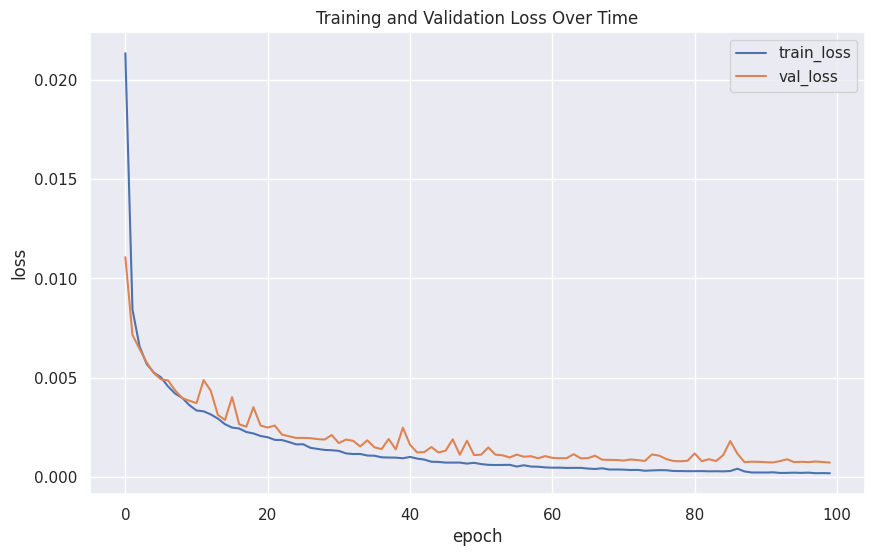

evaluating network perfomance...
Test RMSE: 0.1340


In [90]:
lstm_module = SequenceModel(input_size, hidden_size, sample_length)
lstm_model = ModelTrainer(lstm_module, train_dataloader, val_dataloader, 100, 'lstm_model')
lstm_pred = lstm_model.predict(test_dataloader)

## Bidirectional LSTM model

Epoch 1/100: train_loss: 0.0121 | val_loss: 0.0081 | lr: 0.001
Epoch 2/100: train_loss: 0.0066 | val_loss: 0.006 | lr: 0.001
Epoch 3/100: train_loss: 0.0055 | val_loss: 0.0057 | lr: 0.001
Epoch 4/100: train_loss: 0.0049 | val_loss: 0.0049 | lr: 0.001
Epoch 5/100: train_loss: 0.0045 | val_loss: 0.0045 | lr: 0.001
Epoch 6/100: train_loss: 0.0041 | val_loss: 0.0053 | lr: 0.001
Epoch 7/100: train_loss: 0.0037 | val_loss: 0.0039 | lr: 0.001
Epoch 8/100: train_loss: 0.0032 | val_loss: 0.004 | lr: 0.001
Epoch 9/100: train_loss: 0.003 | val_loss: 0.0032 | lr: 0.001
Epoch 10/100: train_loss: 0.0026 | val_loss: 0.0027 | lr: 0.001
Epoch 11/100: train_loss: 0.0023 | val_loss: 0.0027 | lr: 0.001
Epoch 12/100: train_loss: 0.0022 | val_loss: 0.0027 | lr: 0.001
Epoch 13/100: train_loss: 0.002 | val_loss: 0.0037 | lr: 0.001
Epoch 14/100: train_loss: 0.0019 | val_loss: 0.0021 | lr: 0.001
Epoch 15/100: train_loss: 0.0017 | val_loss: 0.002 | lr: 0.001
Epoch 16/100: train_loss: 0.0015 | val_loss: 0.0019 | 

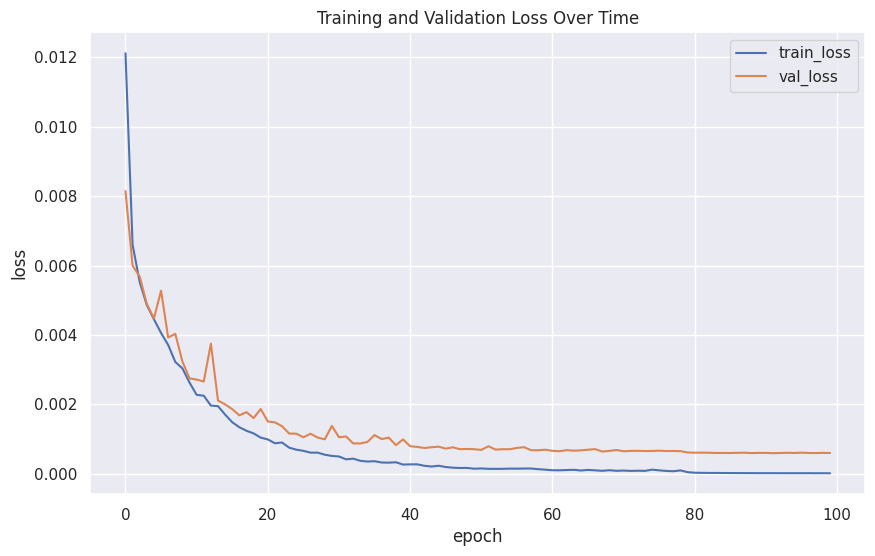

evaluating network perfomance...
Test RMSE: 0.1309


In [91]:
bilstm_module = SequenceModel(input_size, hidden_size, sample_length, bidirectional=True)
bilstm_model = ModelTrainer(bilstm_module, train_dataloader, val_dataloader, 100, 'bilstm_model')
bilstm_pred = bilstm_model.predict(test_dataloader)

## Conv1d model

Epoch 1/100: train_loss: 0.0277 | val_loss: 0.0083 | lr: 0.001
Epoch 2/100: train_loss: 0.0076 | val_loss: 0.0069 | lr: 0.001
Epoch 3/100: train_loss: 0.0065 | val_loss: 0.0062 | lr: 0.001
Epoch 4/100: train_loss: 0.0056 | val_loss: 0.0058 | lr: 0.001
Epoch 5/100: train_loss: 0.0049 | val_loss: 0.0051 | lr: 0.001
Epoch 6/100: train_loss: 0.0046 | val_loss: 0.0053 | lr: 0.001
Epoch 7/100: train_loss: 0.0042 | val_loss: 0.0052 | lr: 0.001
Epoch 8/100: train_loss: 0.0034 | val_loss: 0.0051 | lr: 0.001
Epoch 9/100: train_loss: 0.0031 | val_loss: 0.004 | lr: 0.001
Epoch 10/100: train_loss: 0.0026 | val_loss: 0.0043 | lr: 0.001
Epoch 11/100: train_loss: 0.0025 | val_loss: 0.0036 | lr: 0.001
Epoch 12/100: train_loss: 0.0021 | val_loss: 0.0037 | lr: 0.001
Epoch 13/100: train_loss: 0.0018 | val_loss: 0.0047 | lr: 0.001
Epoch 14/100: train_loss: 0.0018 | val_loss: 0.0035 | lr: 0.001
Epoch 15/100: train_loss: 0.0015 | val_loss: 0.0043 | lr: 0.001
Epoch 16/100: train_loss: 0.0014 | val_loss: 0.004

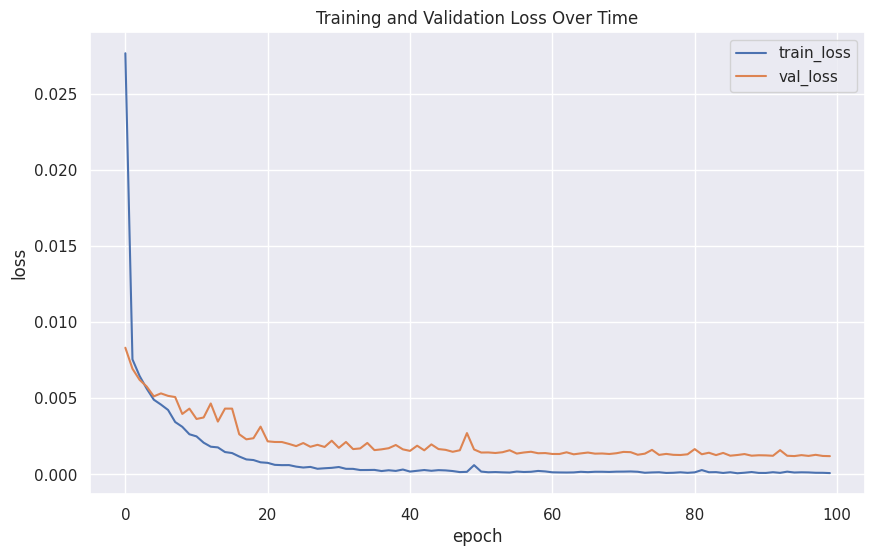

evaluating network perfomance...
Test RMSE: 0.1456


In [92]:
conv1d_module = SequenceModel(input_size, hidden_size, sample_length, lstm=False, bidirectional=False)
conv1d_model = ModelTrainer(conv1d_module, train_dataloader, val_dataloader, 100, 'conv1d_model')
conv1d_pred = conv1d_model.predict(test_dataloader)

In [98]:
pd.DataFrame([performance]).T

,0
XGBRegressor,0.133894
lstm_model,0.134000
bilstm_model,0.130900
conv1d_model,0.145600
LinearRegression,0.136189


# Conclusion

From the experiments perfomred so far, BiDirectional LSTM gave the least error. The objects for each model is saved in the model sub-directory.

In [102]:
state_dict = torch.load('./models/bilstm_model.pth')

model = SequenceModel(input_size, hidden_size, sample_length, bidirectional=True)

model.load_state_dict(state_dict)

<All keys matched successfully>

In [147]:
model.eval()
model = model.to(device)
predictions = []
actuals = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        if i >= 3:
            break
        pred = model(x)
        actuals.append(y.cpu().numpy())
        predictions.append(pred.cpu().numpy())

In [ ]:
predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

# calculate RMSE
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
print(f'RMSE: {rmse}')